In [82]:
df = pd.read_csv('sequences_df.csv')
print("DataFrame loaded successfully from 'sequences_df.csv':")


DataFrame loaded successfully from 'sequences_df.csv':


In [83]:
print(df.groupby('model_name').size())

model_name
deepseek-chat-V3                  800
deepseek-chat-V3.2                800
gemini-2.5-flash                  800
gemini-2.5-flash-preview-05-20    800
gpt-3.5-turbo-0125                800
gpt-4.1                           800
gpt-4.1-mini                      800
gpt-4.1-nano                      800
gpt-5-2025-08-07                  800
gpt-5-nano-2025-08-07             800
prng                              800
dtype: int64


In [21]:
df

experiment_name        model_name  \
0     sequence_generation_10  deepseek-chat-V3   
1     sequence_generation_10  deepseek-chat-V3   
2     sequence_generation_10  deepseek-chat-V3   
3     sequence_generation_10  deepseek-chat-V3   
4     sequence_generation_10  deepseek-chat-V3   
...                      ...               ...   
8795  sequence_generation_10              prng   
8796  sequence_generation_10              prng   
8797  sequence_generation_10              prng   
8798  sequence_generation_10              prng   
8799  sequence_generation_10              prng   

                                               sequence  
0     [3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 7, 3, 5, 9,...  
1     [3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 5, 7, 3, 9,...  
2     [3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 3, 7, 2, 9, 5,...  
3     [3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 2, 5, 7, 3, 9,...  
4     [3, 7, 2, 9, 5, 1, 8, 4, 6, 10, 3, 7, 2, 9, 5,...  
...                                                 ...  
8795  [7, 8, 8, 4, 2, 2, 3, 7, 6, 1, 4, 9, 7, 10, 10...  
8796  [3, 5, 1, 4, 10, 7, 9, 10, 8, 3, 3, 5, 9, 7, 5...  
8797  [7, 9, 2, 4, 9, 7, 5, 4, 2, 7, 8, 1, 5, 5, 10,...  
8798  [3, 6, 1, 8, 6, 6, 1, 2, 7, 8, 4, 8, 2, 8, 6, ...  
8799  [2, 2, 8, 10, 5, 5, 5, 4, 2, 6, 10, 3, 4, 8, 7...  

[8800 rows x 3 columns]

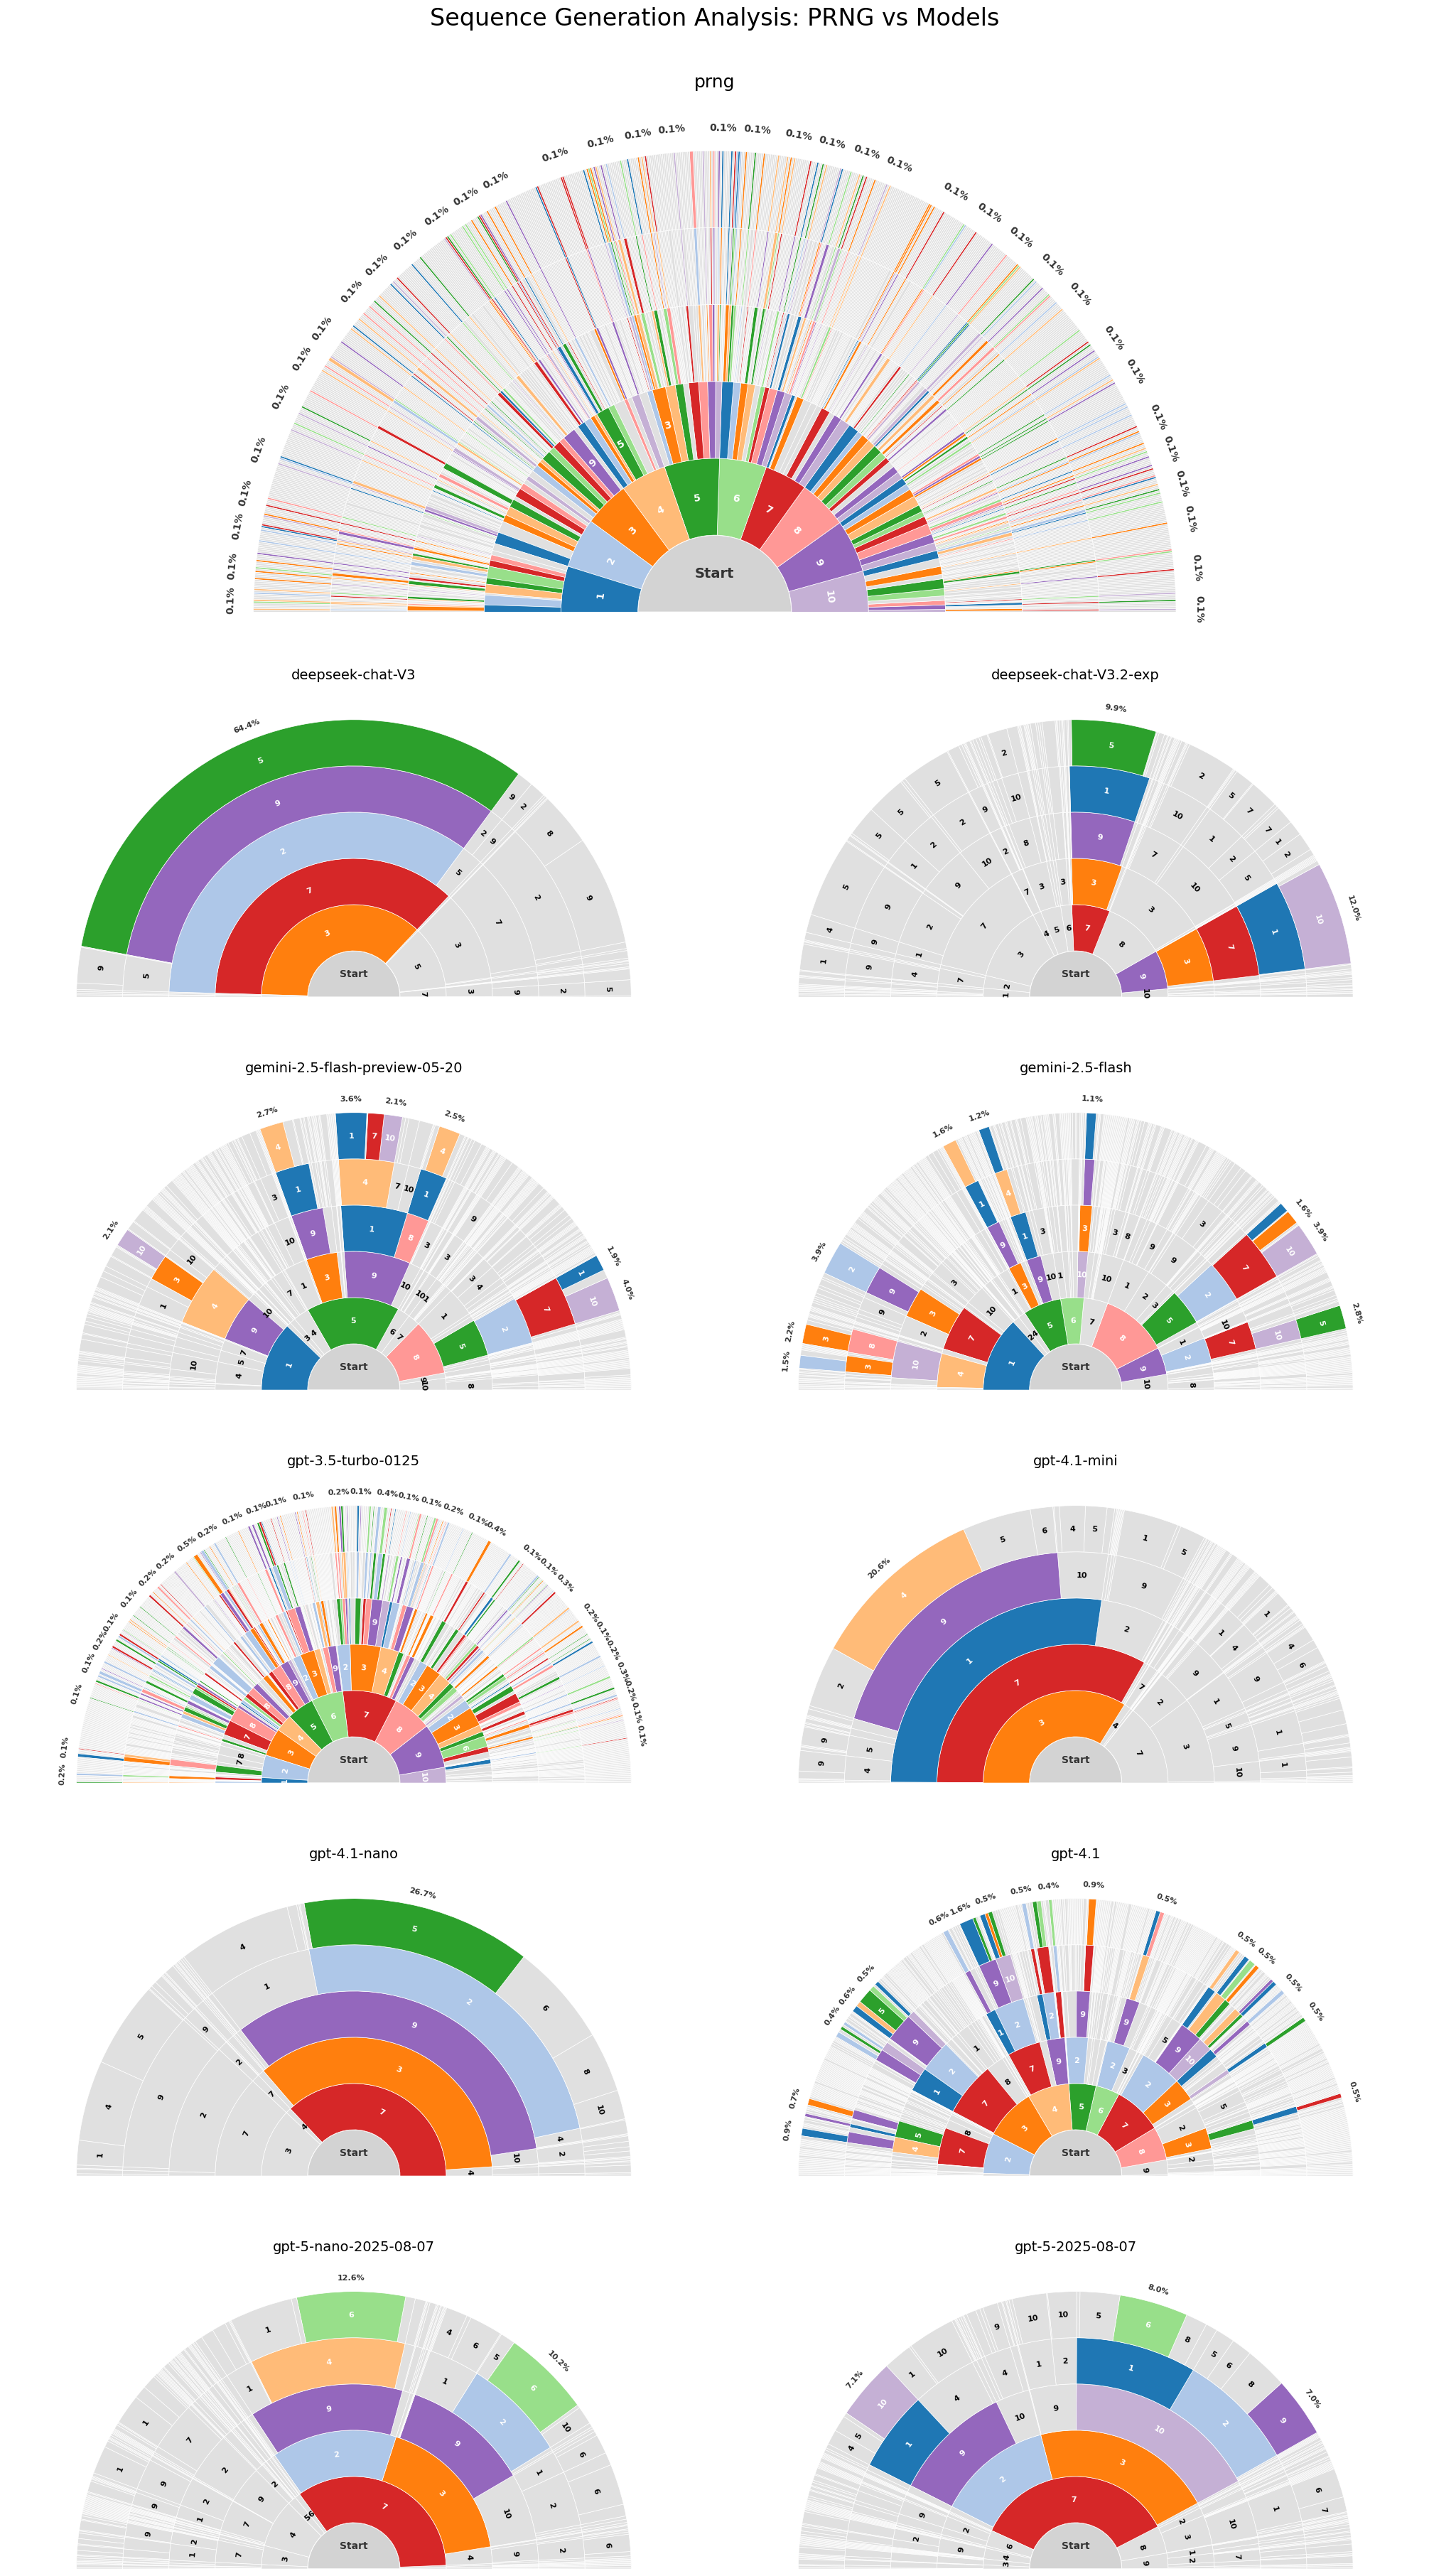

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge
from collections import Counter
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import math

# ==========================================
# CONFIGURATION
# ==========================================
MODEL_COLUMN = 'model_name'
SEQUENCE_COLUMN = 'sequence'
MAX_DEPTH = 5
CUMULATIVE_THRESHOLD = 0.20

# ==========================================
# 1. DATA PREPARATION
# ==========================================
def parse_sequence(seq):
    if isinstance(seq, list):
        return seq
    clean = str(seq).replace('[', '').replace(']', '').replace('...', '')
    try:
        return [int(x.strip()) for x in clean.split(',') if x.strip().isdigit()]
    except:
        return []

# (Assuming 'df' is loaded)
df['parsed_seq'] = df[SEQUENCE_COLUMN].apply(parse_sequence)
df = df[df['parsed_seq'].map(len) >= MAX_DEPTH]

# --- RENAME DEEPSEEK (V3.2) ---
# We rename 'deepseek-chat' to 'deepseek-V3.2-Exp' as requested previously
df[MODEL_COLUMN] = df[MODEL_COLUMN].replace('deepseek-chat-V3.2', 'deepseek-chat-V3.2-exp')

# Identify Center
center_model = 'prng'

# --- CUSTOM SORT ORDERING ---
# Define the exact order for the satellites
custom_order = [
    'deepseek-chat-V3',             'deepseek-chat-V3.2-exp',
    'gemini-2.5-flash-preview-05-20', 'gemini-2.5-flash',
    'gpt-3.5-turbo-0125',           'gpt-4.1-mini',
    'gpt-4.1-nano',                 'gpt-4.1',
    'gpt-5-nano-2025-08-07',        'gpt-5-2025-08-07'
]

# Filter models that actually exist in the dataframe
available_models = set(df[MODEL_COLUMN].unique())
satellite_models = [m for m in custom_order if m in available_models]

# Append any remaining models that weren't in the custom list (just in case)
remaining = [m for m in available_models if m != center_model and m not in satellite_models]
satellite_models.extend(sorted(remaining))

# ==========================================
# 2. HELPER: WEDGES & COLORS
# ==========================================
all_nums = set()
for s in df['parsed_seq']: all_nums.update(s[:MAX_DEPTH])
sorted_nums = sorted(list(all_nums))
cmap = plt.get_cmap('tab20')
val_to_color = {num: cmap(i % 20) for i, num in enumerate(sorted_nums)}

def get_winning_prefixes(subset):
    seqs = [tuple(x[:MAX_DEPTH]) for x in subset['parsed_seq']]
    counts = Counter(seqs)
    total = sum(counts.values())
    sorted_paths = counts.most_common()

    current_mass = 0.0
    winning_prefixes = set()
    winning_prefixes.add(())

    for seq, count in sorted_paths:
        prob = count / total
        current_mass += prob
        for i in range(1, len(seq) + 1):
            winning_prefixes.add(seq[:i])
        if current_mass >= CUMULATIVE_THRESHOLD:
            break
    return winning_prefixes

def get_wedges_for_model(model_name):
    subset = df[df[MODEL_COLUMN] == model_name].copy()
    winning_prefixes = get_winning_prefixes(subset)
    wedges = []

    def build(current_indices, depth, start_angle, end_angle, current_path_tuple, parent_cum_prob):
        if depth >= MAX_DEPTH: return

        values = [subset.iloc[i]['parsed_seq'][depth] for i in current_indices]
        val_map = {i: v for i, v in zip(current_indices, values)}
        counts = Counter(values)
        total = sum(counts.values())

        # Sort DESCENDING (10 -> 1)
        sorted_branches = sorted(counts.items(), key=lambda x: x[0], reverse=True)

        current_start = start_angle
        total_angle = end_angle - start_angle

        for val, count in sorted_branches:
            local_prob = count / total
            absolute_prob = parent_cum_prob * local_prob

            wedge_angle = total_angle * local_prob
            current_end = current_start + wedge_angle

            new_path_tuple = current_path_tuple + (val,)
            is_winner = new_path_tuple in winning_prefixes

            color = val_to_color.get(val, 'grey') if is_winner else '#E0E0E0'

            wedges.append({
                'depth': depth, 'val': val,
                'start': current_start, 'end': current_end,
                'color': color, 'is_winner': is_winner,
                'absolute_prob': absolute_prob
            })

            next_indices = [idx for idx in current_indices if val_map[idx] == val]
            build(next_indices, depth+1, current_start, current_end, new_path_tuple, absolute_prob)
            current_start += wedge_angle

    build(range(len(subset)), 0, 0, np.pi, (), 1.0)
    return wedges

# ==========================================
# 3. DRAWING FUNCTION
# ==========================================
def draw_sunburst(ax, model_name, is_center=False):
    wedges = get_wedges_for_model(model_name)
    ax.set_aspect('equal')

    ax.add_patch(Wedge((0, 0), 1, 0, 180, color='lightgray', ec='white'))

    # Fonts
    fontsize_title = 18 if is_center else 14
    fontsize_start = 14 if is_center else 10
    fontsize_inner = 10 if is_center else 8
    fontsize_outer = 10 if is_center else 8

    ax.text(0, 0.5, "Start", ha='center', va='center', fontsize=fontsize_start,
            fontweight='bold', color='#333333')

    placed_label_angles = []

    for w in wedges:
        r_inner = w['depth'] + 1
        r_outer = w['depth'] + 2
        theta1 = np.degrees(w['start'])
        theta2 = np.degrees(w['end'])

        patch = Wedge((0, 0), r_outer, theta1, theta2, width=1.0,
                      facecolor=w['color'], edgecolor='white', linewidth=0.5)
        ax.add_patch(patch)

        mid_theta = np.radians((theta1 + theta2) / 2)
        mid_deg = np.degrees(mid_theta)

        # Inner Text
        if (theta2 - theta1) > 3:
            mid_r = (r_inner + r_outer) / 2
            x = mid_r * np.cos(mid_theta)
            y = mid_r * np.sin(mid_theta)
            rot = mid_deg - 90
            if rot < -90: rot += 180
            txt_col = 'black' if w['color'] == '#E0E0E0' else 'white'
            ax.text(x, y, str(w['val']), ha='center', va='center', rotation=rot,
                    fontsize=fontsize_inner, fontweight='bold', color=txt_col)

        # Outer Text
        if w['is_winner'] and w['depth'] == MAX_DEPTH - 1:
            collision = False
            for placed_angle in placed_label_angles:
                if abs(placed_angle - mid_deg) < 4.0:
                    collision = True
                    break

            if not collision:
                placed_label_angles.append(mid_deg)
                label_r = r_outer + 0.3
                x_lbl = label_r * np.cos(mid_theta)
                y_lbl = label_r * np.sin(mid_theta)
                rot_lbl = mid_deg - 90
                if rot_lbl < -90: rot_lbl += 180

                prob_text = f"{w['absolute_prob']:.1%}"
                ax.text(x_lbl, y_lbl, prob_text, ha='center', va='center', rotation=rot_lbl,
                        fontsize=fontsize_outer, fontweight='bold', color='#333333')

    limit = MAX_DEPTH + 2.5
    ax.set_xlim(-limit, limit)
    ax.set_ylim(0, limit)
    ax.axis('off')

    ax.set_title(f"{model_name}", fontsize=fontsize_title, y=0.9)

# ==========================================
# 4. LAYOUT: TOP + GRID (CUSTOM ORDER)
# ==========================================
n_sat = len(satellite_models)
n_sat_rows = math.ceil(n_sat / 2)
total_rows = 1 + n_sat_rows

hr = [1.5] + [1.0] * n_sat_rows

fig = plt.figure(figsize=(20, 6 * total_rows), constrained_layout=True)
gs = gridspec.GridSpec(total_rows, 2, figure=fig, height_ratios=hr)

# A. Center (True Random)
ax_center = fig.add_subplot(gs[0, :])
draw_sunburst(ax_center, center_model, is_center=True)

# B. Satellites (Sorted by custom_order)
for i, model in enumerate(satellite_models):
    row_idx = 1 + (i // 2)
    col_idx = i % 2
    ax_sat = fig.add_subplot(gs[row_idx, col_idx])
    draw_sunburst(ax_sat, model, is_center=False)

plt.suptitle("Sequence Generation Analysis: PRNG vs Models", fontsize=24, y=1.01)

# Save to EPS
plt.savefig('sequence_analysis_sunburst.eps', format='eps', bbox_inches='tight')
plt.show()

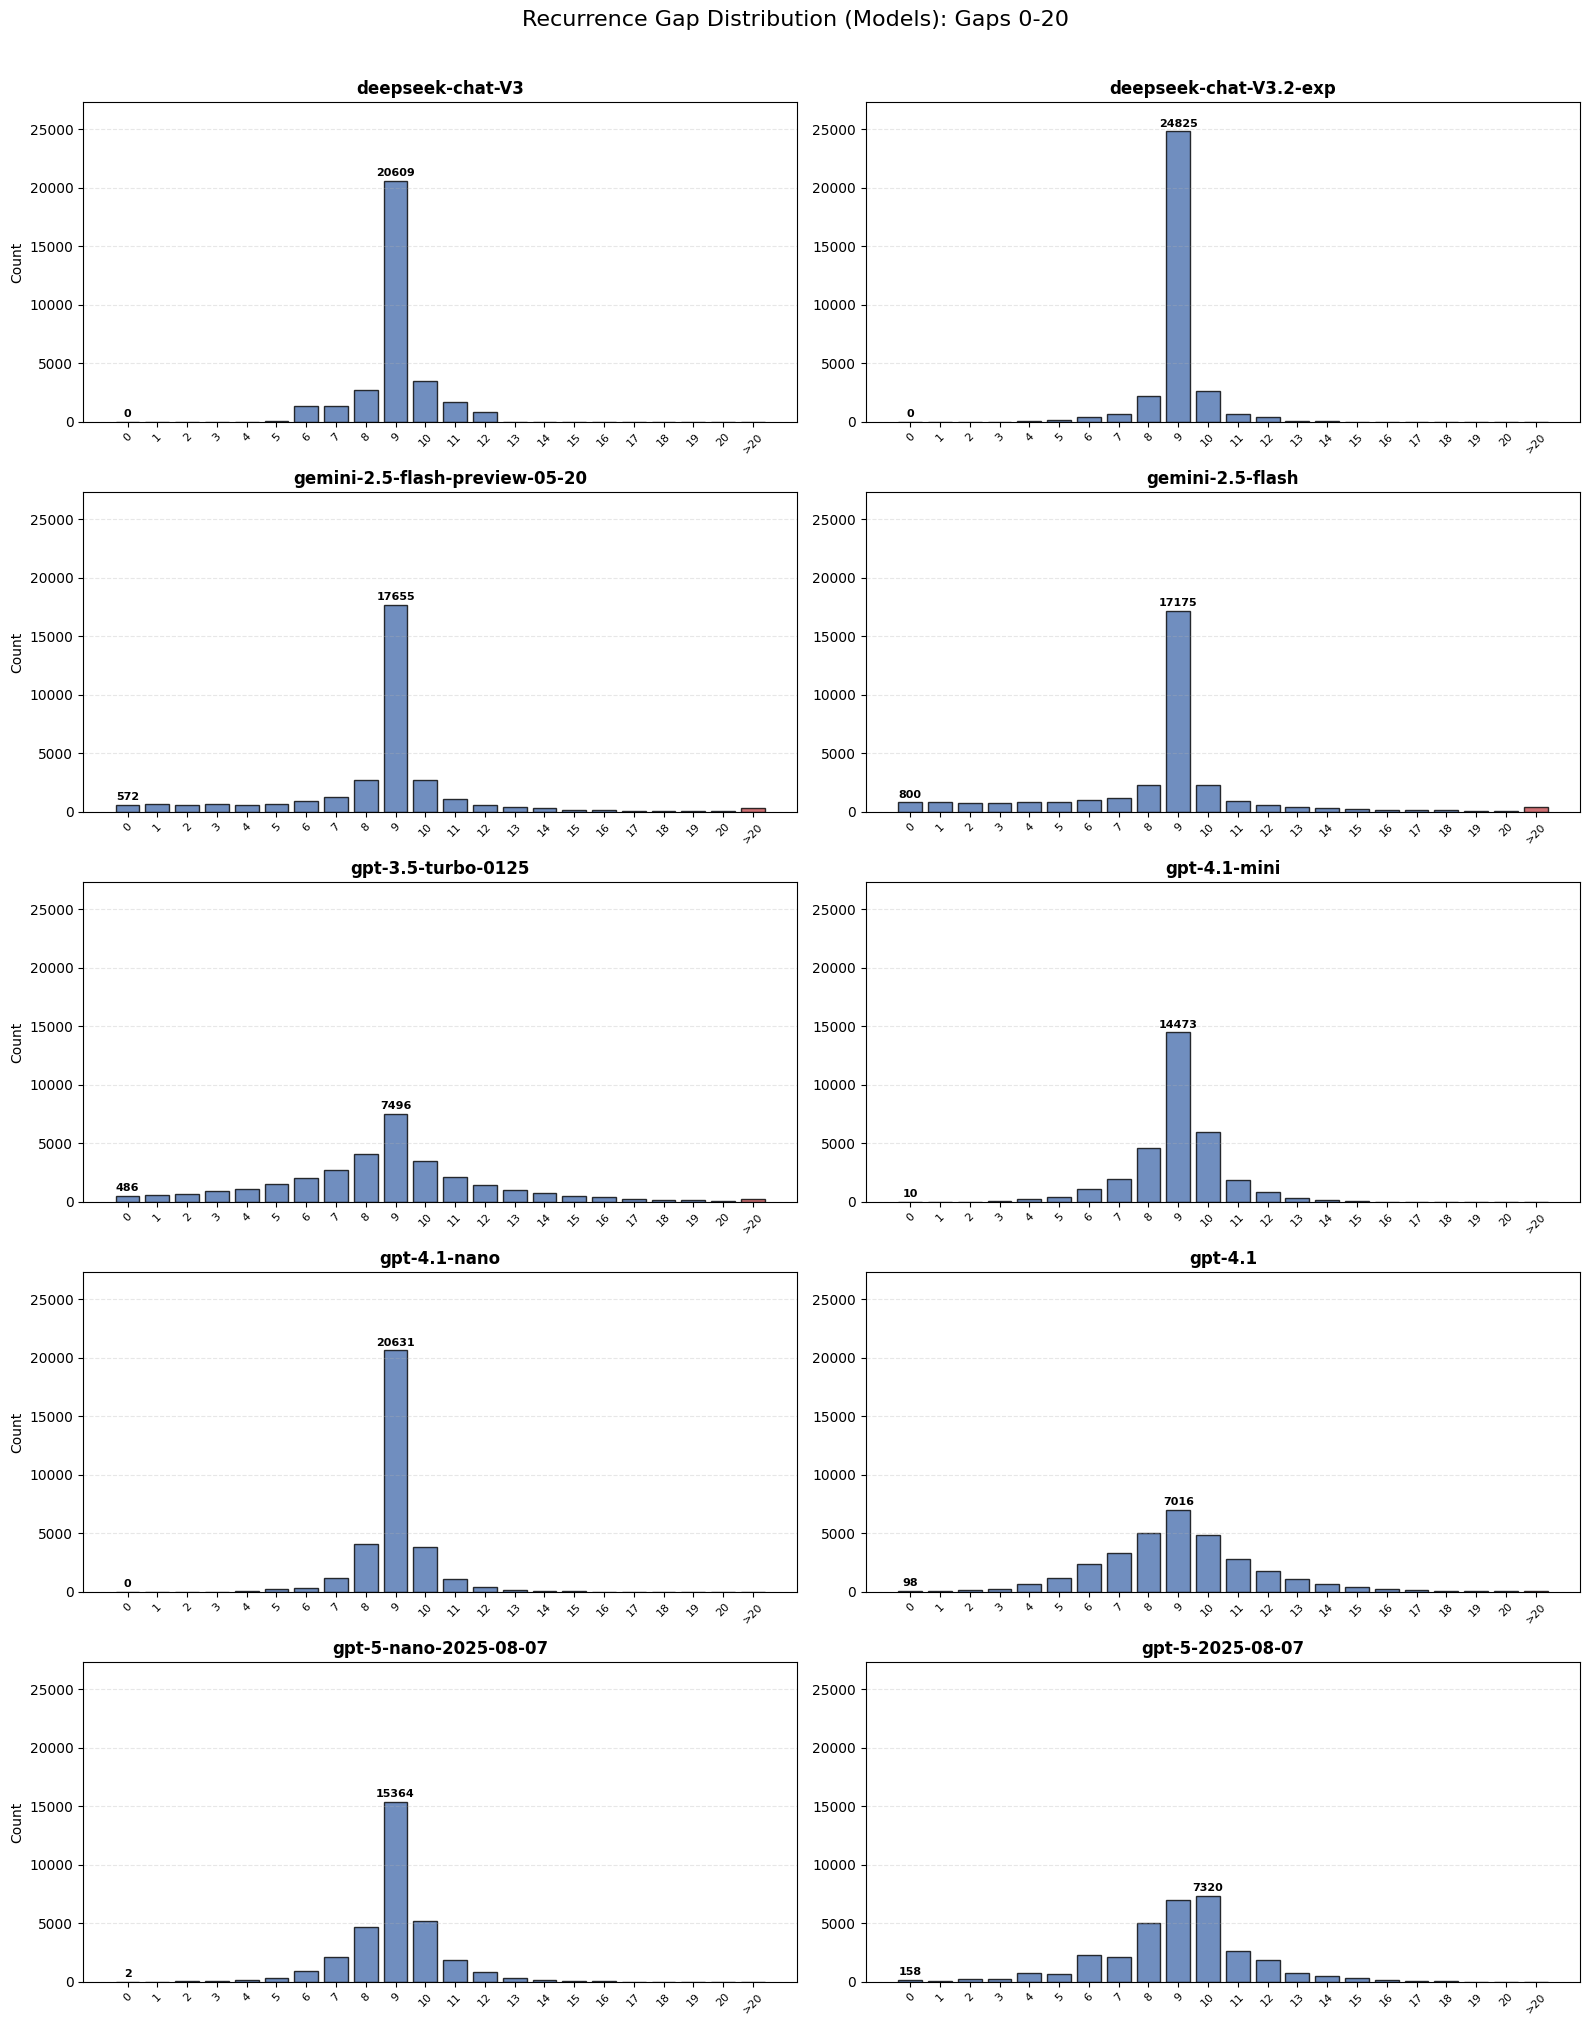

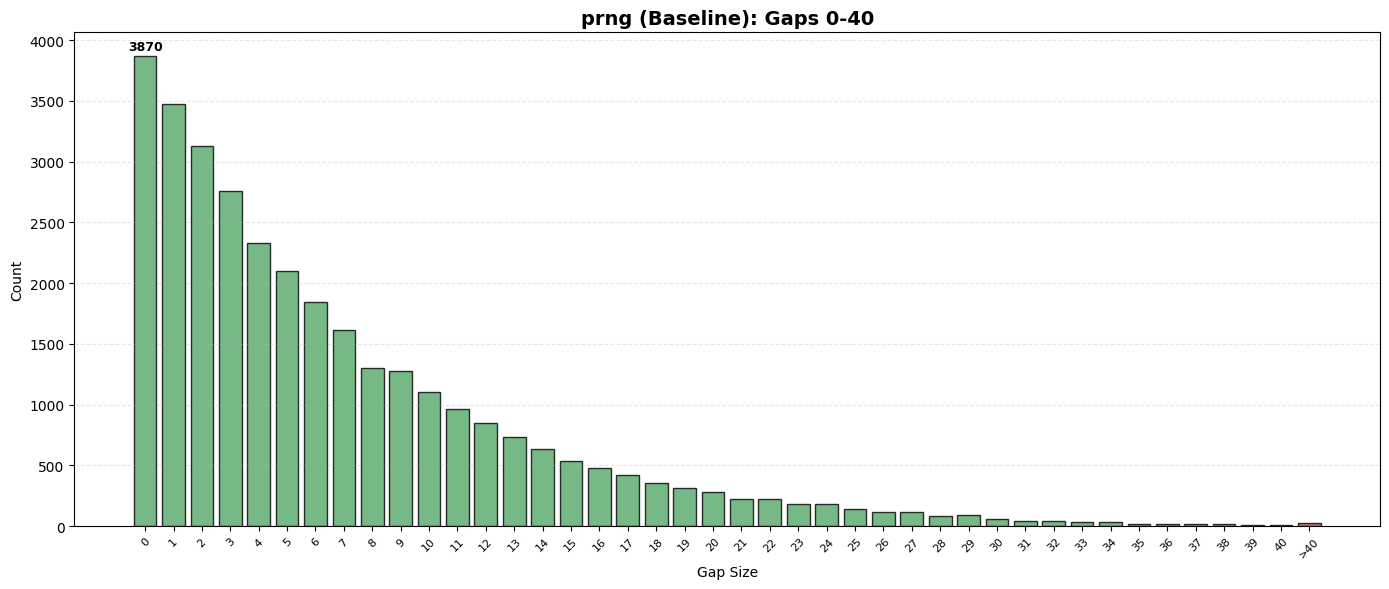

In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import matplotlib.gridspec as gridspec

# ==========================================
# 1. DATA PREP
# ==========================================

custom_order = [
    'deepseek-chat-V3',             'deepseek-chat-V3.2-exp',
    'gemini-2.5-flash-preview-05-20', 'gemini-2.5-flash',
    'gpt-3.5-turbo-0125',           'gpt-4.1-mini',
    'gpt-4.1-nano',                 'gpt-4.1',
    'gpt-5-nano-2025-08-07',        'gpt-5-2025-08-07'
]
center_model = 'prng'

def get_recurrence_gaps(seq):
    if isinstance(seq, str):
        clean = seq.replace('[', '').replace(']', '').replace('...', '')
        try: seq = [int(x.strip()) for x in clean.split(',') if x.strip().isdigit()]
        except: return []
    locs = collections.defaultdict(list)
    for i, num in enumerate(seq):
        locs[num].append(i)
    gaps = []
    for indices in locs.values():
        for i in range(len(indices) - 1):
            gap = (indices[i+1] - indices[i]) - 1
            gaps.append(gap)
    return gaps

all_models = df['model_name'].unique().tolist()
raw_results = {}
for model in all_models:
    subset = df[df['model_name'] == model]
    all_gaps = []
    for seq in subset['parsed_seq']:
        all_gaps.extend(get_recurrence_gaps(seq))
    raw_results[model] = collections.Counter(all_gaps)

# ==========================================
# 2. PLOT 1: MODELS (0-20)
# ==========================================
sat_max_gap = 20
satellite_models = [m for m in custom_order if m in all_models]

sat_data = {}
for m in satellite_models:
    counts = raw_results[m]
    row = {}
    for g in range(sat_max_gap + 1):
        row[g] = counts.get(g, 0)
    row[f'>{sat_max_gap}'] = sum(c for g, c in counts.items() if g > sat_max_gap)
    sat_data[m] = row
sat_df = pd.DataFrame.from_dict(sat_data, orient='index')

y_limit = sat_df.max().max() * 1.1

n_cols = 2
n_rows = (len(satellite_models) + n_cols - 1) // n_cols

fig1 = plt.figure(figsize=(16, 4 * n_rows))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = fig1.add_subplot(gs1[row_idx, col_idx])

    row_vals = sat_df.loc[model]
    x_labels = [str(g) for g in range(sat_max_gap + 1)] + [f'>{sat_max_gap}']
    y_vals = row_vals.values
    x_pos = range(len(x_labels))

    bar_colors = ['#4c72b0'] * (len(x_pos)-1) + ['#c44e52']
    ax.bar(x_pos, y_vals, color=bar_colors, edgecolor='black', alpha=0.8)

    ax.set_ylim(0, y_limit)
    ax.set_title(model, fontsize=12, fontweight='bold')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, fontsize=8)
    if col_idx == 0: ax.set_ylabel("Count")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    peak_idx = np.argmax(y_vals)
    indices_to_label = {0, peak_idx}

    for idx in indices_to_label:
        val = y_vals[idx]
        ax.annotate(f'{val}', xy=(idx, val), xytext=(0, 2),
                    textcoords="offset points", ha='center', va='bottom',
                    fontsize=8, fontweight='bold', color='black')

plt.suptitle(f"Recurrence Gap Distribution (Models): Gaps 0-{sat_max_gap}", fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('recurrence_gap_models.eps', format='eps', bbox_inches='tight') # Save as EPS
plt.show()

# ==========================================
# 3. PLOT 2: TRUE RANDOM (0-40)
# ==========================================
if center_model in all_models:
    rand_max_gap = 40
    counts = raw_results[center_model]
    row = {}
    for g in range(rand_max_gap + 1):
        row[g] = counts.get(g, 0)
    row[f'>{rand_max_gap}'] = sum(c for g, c in counts.items() if g > rand_max_gap)

    fig2 = plt.figure(figsize=(14, 6))
    ax2 = fig2.add_subplot(111)

    x_labels = [str(g) for g in range(rand_max_gap + 1)] + [f'>{rand_max_gap}']
    y_vals = list(row.values())
    x_pos = range(len(x_labels))

    bar_colors = ['#55a868'] * (len(x_pos)-1) + ['#c44e52']
    bars = ax2.bar(x_pos, y_vals, color=bar_colors, edgecolor='black', alpha=0.8)

    ax2.set_title(f"{center_model} (Baseline): Gaps 0-{rand_max_gap}", fontsize=14, fontweight='bold')

    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(x_labels, rotation=45, fontsize=8)

    ax2.set_xlabel("Gap Size")
    ax2.set_ylabel("Count")
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    peak_idx = np.argmax(y_vals)
    indices_to_label = {0, peak_idx}

    for idx in indices_to_label:
        val = y_vals[idx]
        ax2.annotate(f'{val}', xy=(idx, val), xytext=(0, 2),
                     textcoords="offset points", ha='center', va='bottom',
                     fontsize=9, fontweight='bold', color='black')

    plt.tight_layout()
    plt.savefig('recurrence_gap_truerandom.eps', format='eps', bbox_inches='tight') # Save as EPS
    plt.show()

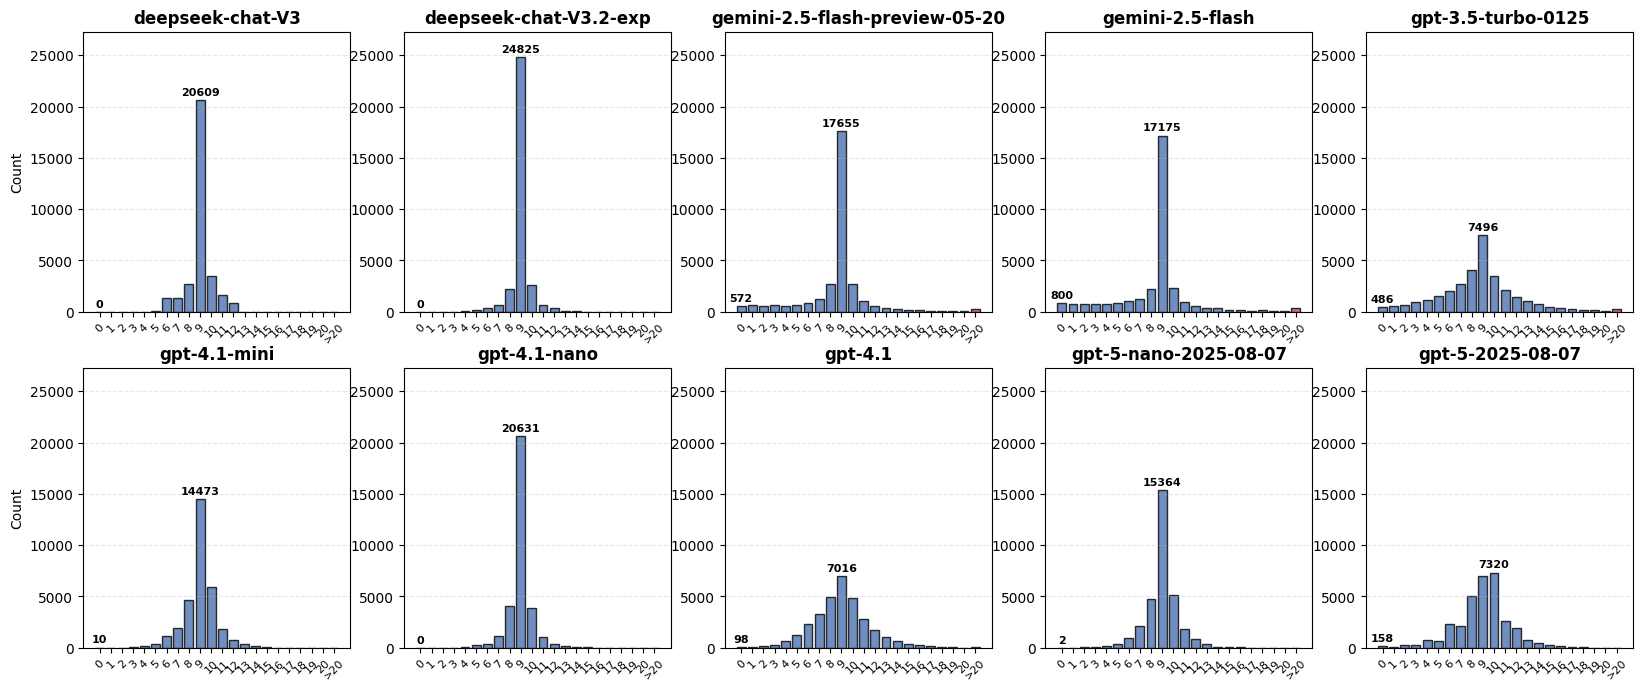

In [24]:
# 5x2 Grid
n_rows = 2
n_cols = 5

fig1 = plt.figure(figsize=(4 * n_cols, 8))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = fig1.add_subplot(gs1[row_idx, col_idx])

    row_vals = sat_df.loc[model]
    x_labels = [str(g) for g in range(sat_max_gap + 1)] + [f'>{sat_max_gap}']
    y_vals = row_vals.values
    x_pos = range(len(x_labels))

    bar_colors = ['#4c72b0'] * (len(x_pos) - 1) + ['#c44e52']
    ax.bar(x_pos, y_vals, color=bar_colors, edgecolor='black', alpha=0.8)

    ax.set_ylim(0, y_limit)
    ax.set_title(model, fontsize=12, fontweight='bold')

    ax.set_xticks(x_pos)
    ax.set_xticklabels(x_labels, rotation=45, fontsize=8)
    if col_idx == 0:
        ax.set_ylabel("Count")
    ax.grid(axis='y', linestyle='--', alpha=0.3)

    peak_idx = np.argmax(y_vals)
    indices_to_label = {0, peak_idx}
    for idx in indices_to_label:
        val = y_vals[idx]
        ax.annotate(f'{val}', xy=(idx, val), xytext=(0, 2),
                    textcoords="offset points", ha='center', va='bottom',
                    fontsize=8, fontweight='bold')


/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number o

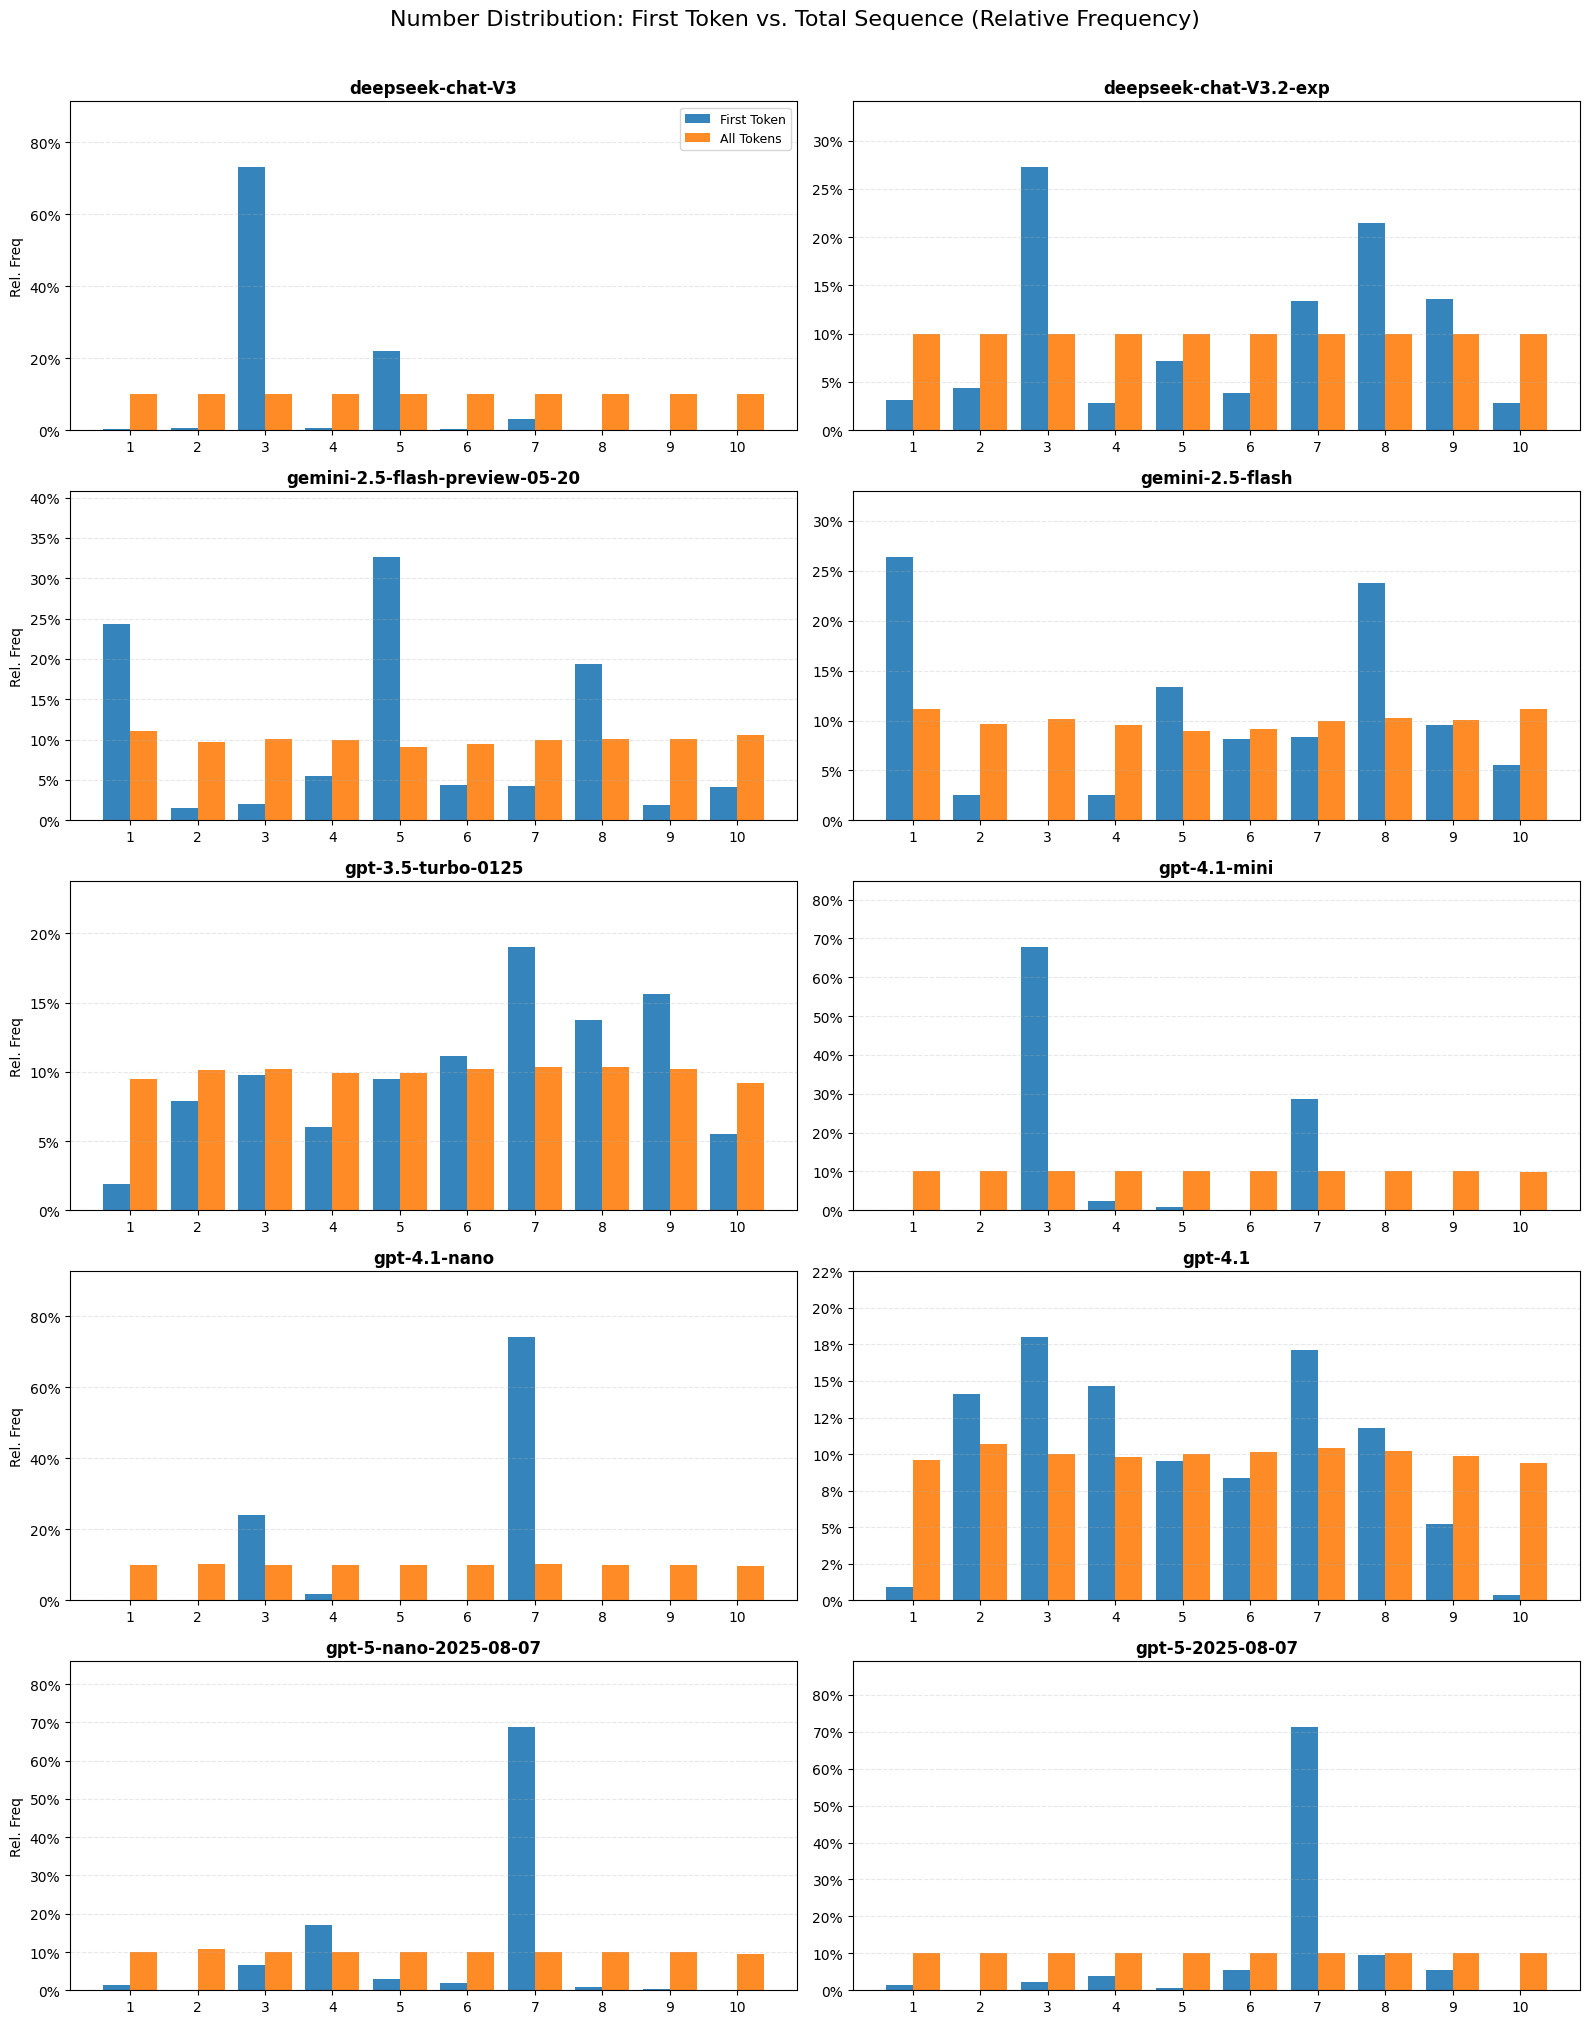

/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])


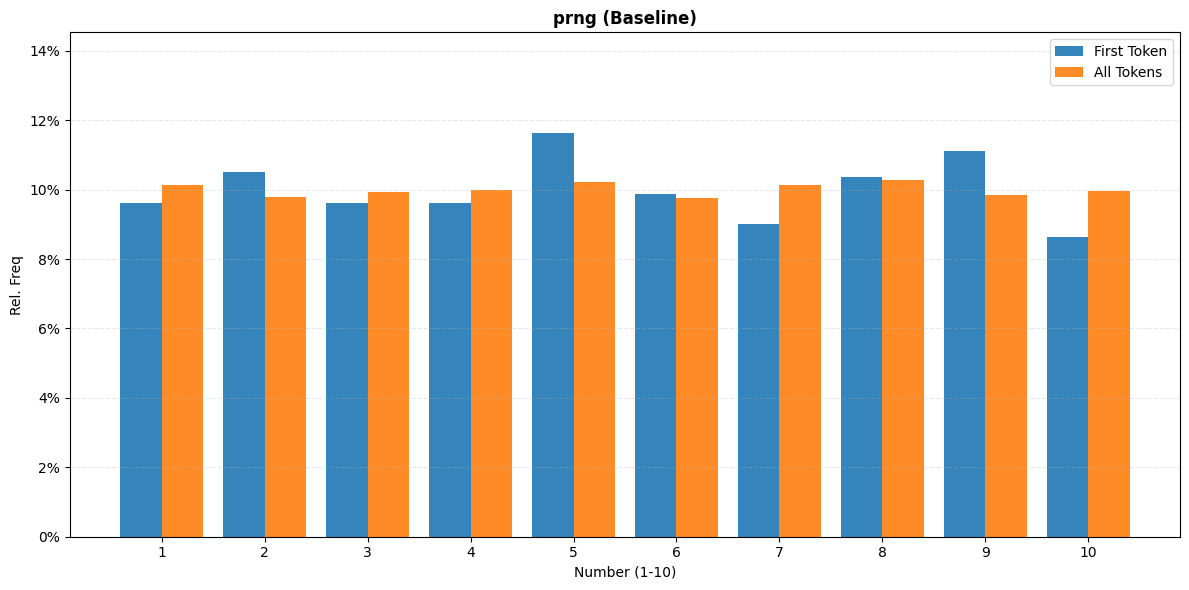

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import matplotlib.gridspec as gridspec

custom_order = [
    'deepseek-chat-V3',             'deepseek-chat-V3.2-exp',
    'gemini-2.5-flash-preview-05-20', 'gemini-2.5-flash',
    'gpt-3.5-turbo-0125',           'gpt-4.1-mini',
    'gpt-4.1-nano',                 'gpt-4.1',
    'gpt-5-nano-2025-08-07',        'gpt-5-2025-08-07'
]
center_model = 'prng'
all_models = df['model_name'].unique().tolist()

# ==========================================
# 2. CALCULATION LOGIC (RELATIVE FREQ)
# ==========================================
def get_rel_distributions(subset):
    # 1. First Number Distribution
    first_nums = [seq[0] for seq in subset['parsed_seq'] if len(seq) > 0]
    total_seqs = len(first_nums)
    first_counts = collections.Counter(first_nums)

    # 2. Total Number Distribution
    all_nums = [num for seq in subset['parsed_seq'] for num in seq]
    total_tokens = len(all_nums)
    total_counts = collections.Counter(all_nums)

    first_dist = []
    total_dist = []

    for i in range(1, 11):
        # Calculate Relative Freq (0.0 - 1.0)
        f_val = first_counts.get(i, 0) / total_seqs if total_seqs > 0 else 0
        t_val = total_counts.get(i, 0) / total_tokens if total_tokens > 0 else 0
        first_dist.append(f_val)
        total_dist.append(t_val)

    return first_dist, total_dist

def plot_dist_comparison(ax, model_name, first_dist, total_dist):
    x = np.arange(1, 11)
    width = 0.4

    ax.bar(x - width/2, first_dist, width, label='First Token', color='#1f77b4', alpha=0.9)
    ax.bar(x + width/2, total_dist, width, label='All Tokens', color='#ff7f0e', alpha=0.9)

    ax.set_title(model_name, fontsize=12, fontweight='bold')
    ax.set_xticks(x)

    max_val = max(max(first_dist), max(total_dist))
    ax.set_ylim(0, max_val * 1.25)

    vals = ax.get_yticks()
    ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])

# ==========================================
# 3. PLOT 1: SATELLITES GRID
# ==========================================
satellite_models = [m for m in custom_order if m in all_models]
n_cols = 2
n_rows = (len(satellite_models) + n_cols - 1) // n_cols

fig1 = plt.figure(figsize=(16, 4 * n_rows))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    subset = df[df['model_name'] == model]
    f_dist, t_dist = get_rel_distributions(subset)

    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = fig1.add_subplot(gs1[row_idx, col_idx])

    plot_dist_comparison(ax, model, f_dist, t_dist)

    if col_idx == 0: ax.set_ylabel("Rel. Freq")
    if i == 0: ax.legend(loc='upper right', fontsize=9)
    ax.grid(axis='y', linestyle='--', alpha=0.3)

plt.suptitle("Number Distribution: First Token vs. Total Sequence (Relative Frequency)", fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('first_number_distribution_models.eps', format='eps', bbox_inches='tight') # Save as EPS
plt.show()

# ==========================================
# 4. PLOT 2: TRUE RANDOM
# ==========================================
if center_model in all_models:
    subset = df[df['model_name'] == center_model]
    f_dist, t_dist = get_rel_distributions(subset)

    fig2 = plt.figure(figsize=(12, 6))
    ax2 = fig2.add_subplot(111)

    plot_dist_comparison(ax2, center_model + " (Baseline)", f_dist, t_dist)

    ax2.set_ylabel("Rel. Freq")
    ax2.set_xlabel("Number (1-10)")
    ax2.legend()
    ax2.grid(axis='y', linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.savefig('first_number_distribution_truerandom.eps', format='eps', bbox_inches='tight') # Save as EPS
    plt.show()

/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
/tmp/ipython-input-2887217332.py:67: UserWarning: set_ticklabels() should only be used with a fixed number o

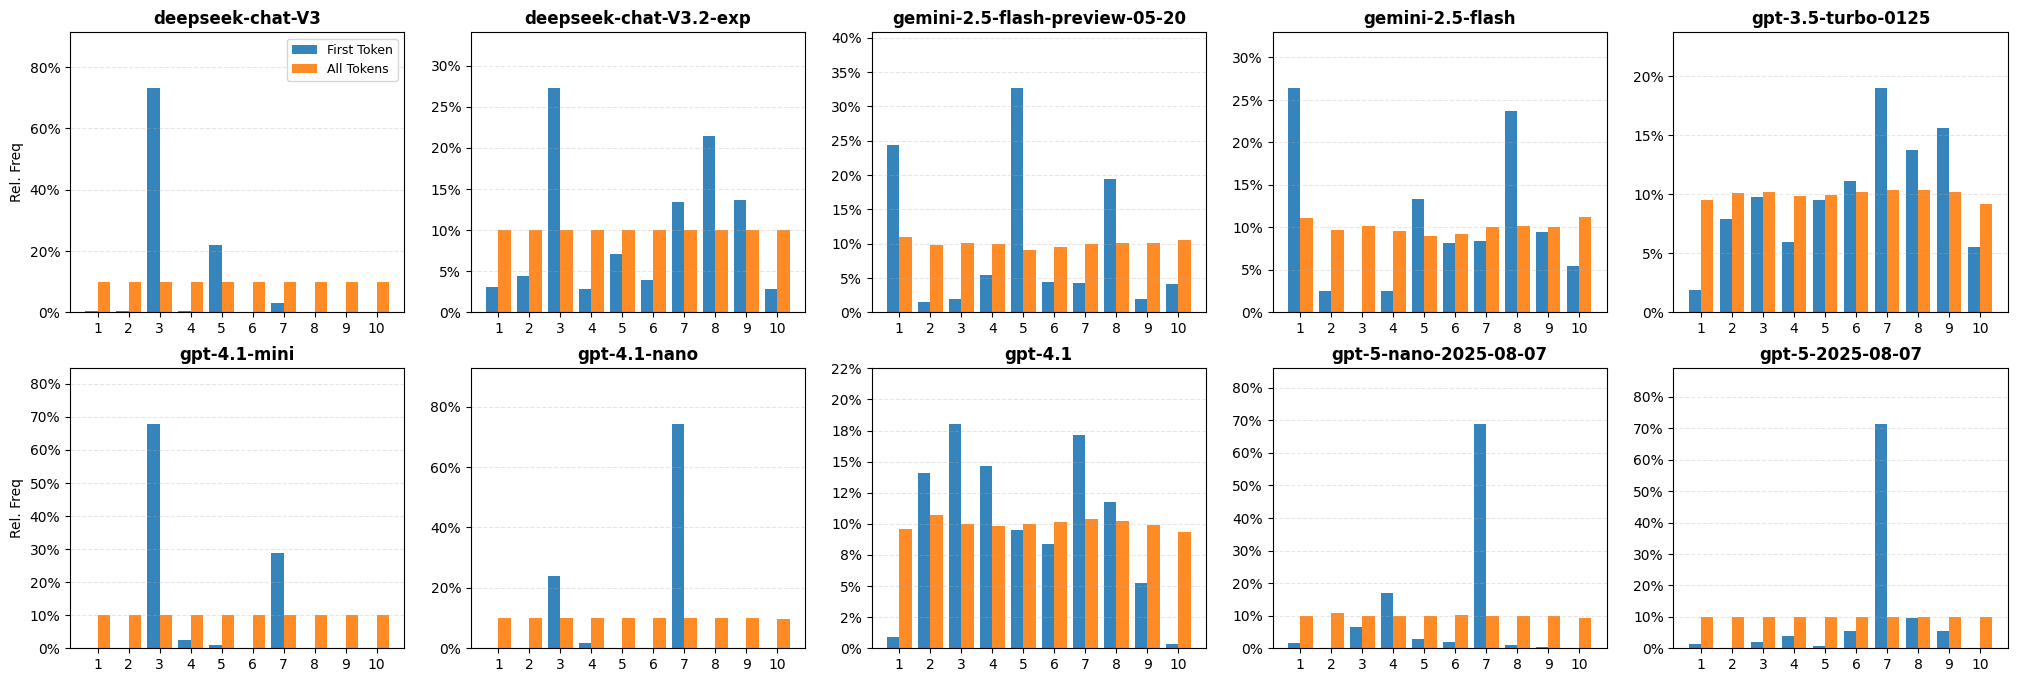

In [26]:
# 5x2 grid
n_rows = 2
n_cols = 5

fig1 = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    subset = df[df['model_name'] == model]
    f_dist, t_dist = get_rel_distributions(subset)

    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = fig1.add_subplot(gs1[row_idx, col_idx])

    plot_dist_comparison(ax, model, f_dist, t_dist)

    if col_idx == 0:
        ax.set_ylabel("Rel. Freq")
    if i == 0:
        ax.legend(loc='upper right', fontsize=9)

    ax.grid(axis='y', linestyle='--', alpha=0.3)


In [27]:
import pandas as pd
import collections
import numpy as np

# ==========================================
# 1. DATA PREPARATION
# ==========================================
def parse_sequence(seq):
    if isinstance(seq, list):
        return seq
    clean = str(seq).replace('[', '').replace(']', '').replace('...', '')
    try:
        return [int(x.strip()) for x in clean.split(',') if x.strip().isdigit()]
    except:
        return []

df['parsed_seq'] = df['sequence'].apply(parse_sequence)

if 'model_name' in df.columns:
    df['model_name'] = df['model_name'].replace(['deepseek-chat', 'deepseek-V3.2-Exp','deepseek-chat-V3.2'], 'deepseek-chat-V3.2-exp')

def get_first_number_distribution(subset):
    first_nums = [seq[0] for seq in subset['parsed_seq'] if len(seq) > 0]
    total_seqs = len(first_nums)
    first_counts = collections.Counter(first_nums)

    first_dist = {}
    for i in range(1, 11):
        f_val = first_counts.get(i, 0) / total_seqs if total_seqs > 0 else 0
        first_dist[i] = f_val
    return first_dist

# ==========================================
# 2. GENERATE TABLE DATA (Most Popular Number & Average)
# ==========================================

all_models = df['model_name'].unique()
most_popular_results = []

for model_name in all_models:
    subset = df[df['model_name'] == model_name]
    first_dist = get_first_number_distribution(subset)

    # Calculate the average number in sequence
    all_numbers_in_model = [num for seq in subset['parsed_seq'] for num in seq]
    average_number = np.mean(all_numbers_in_model) if all_numbers_in_model else 0

    if first_dist:
        # Find the number with the maximum percentage
        most_popular_num = max(first_dist, key=first_dist.get)
        most_popular_percentage = first_dist[most_popular_num]
        most_popular_results.append({
            'Model': model_name,
            'Most Popular First Number': most_popular_num,
            'Percentage': most_popular_percentage,
            'Average Number in Sequence': average_number
        })

df_most_popular = pd.DataFrame(most_popular_results)

df_most_popular = df_most_popular.sort_values(by='Percentage', ascending=False).reset_index(drop=True)

df_most_popular['Percentage'] = df_most_popular['Percentage'].apply(lambda x: f"{x:.2%}")

df_most_popular['Average Number in Sequence'] = df_most_popular['Average Number in Sequence'].apply(lambda x: f"{x:.2f}")

print("Most Popular First Number, its Percentage, and Average Number in Sequence by Model (Descending):")
display(df_most_popular)


Most Popular First Number, its Percentage, and Average Number in Sequence by Model (Descending):


Model  Most Popular First Number Percentage  \
0                     gpt-4.1-nano                          7     74.12%   
1                 deepseek-chat-V3                          3     73.12%   
2                 gpt-5-2025-08-07                          7     71.25%   
3            gpt-5-nano-2025-08-07                          7     68.75%   
4                     gpt-4.1-mini                          3     67.75%   
5   gemini-2.5-flash-preview-05-20                          5     32.62%   
6           deepseek-chat-V3.2-exp                          3     27.25%   
7                 gemini-2.5-flash                          1     26.38%   
8               gpt-3.5-turbo-0125                          7     19.00%   
9                          gpt-4.1                          3     18.00%   
10                            prng                          5     11.62%   

   Average Number in Sequence  
0                        5.48  
1                        5.50  
2                        5.50  
3                        5.45  
4                        5.50  
5                        5.49  
6                        5.50  
7                        5.52  
8                        5.53  
9                        5.48  
10                       5.50

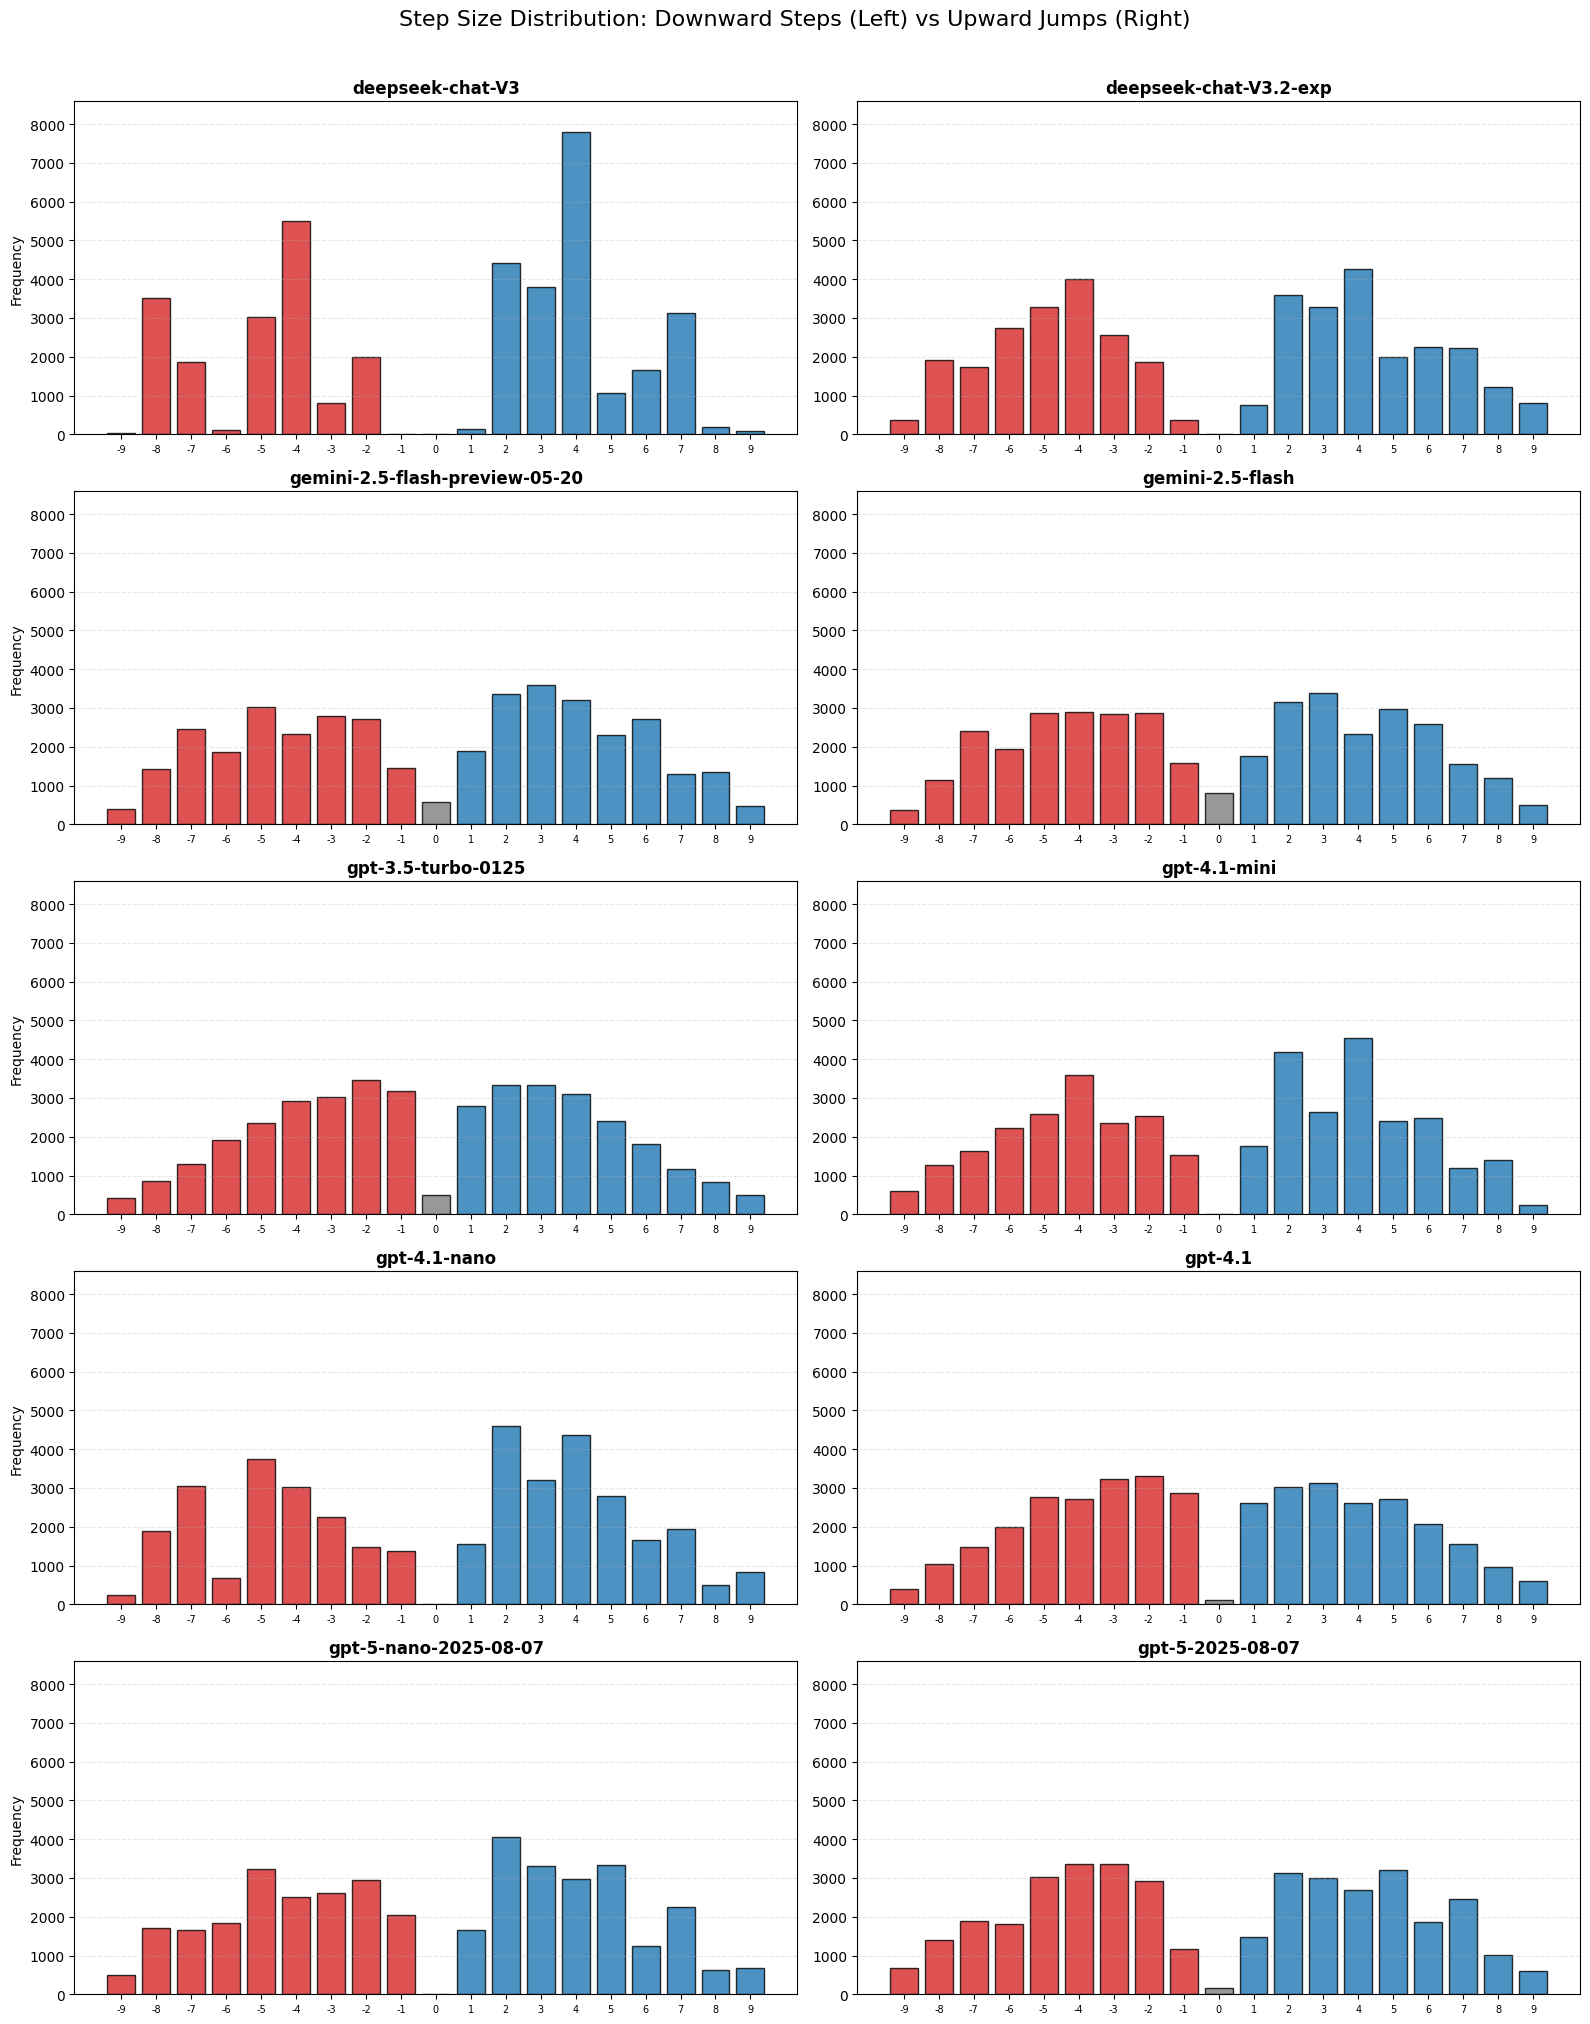

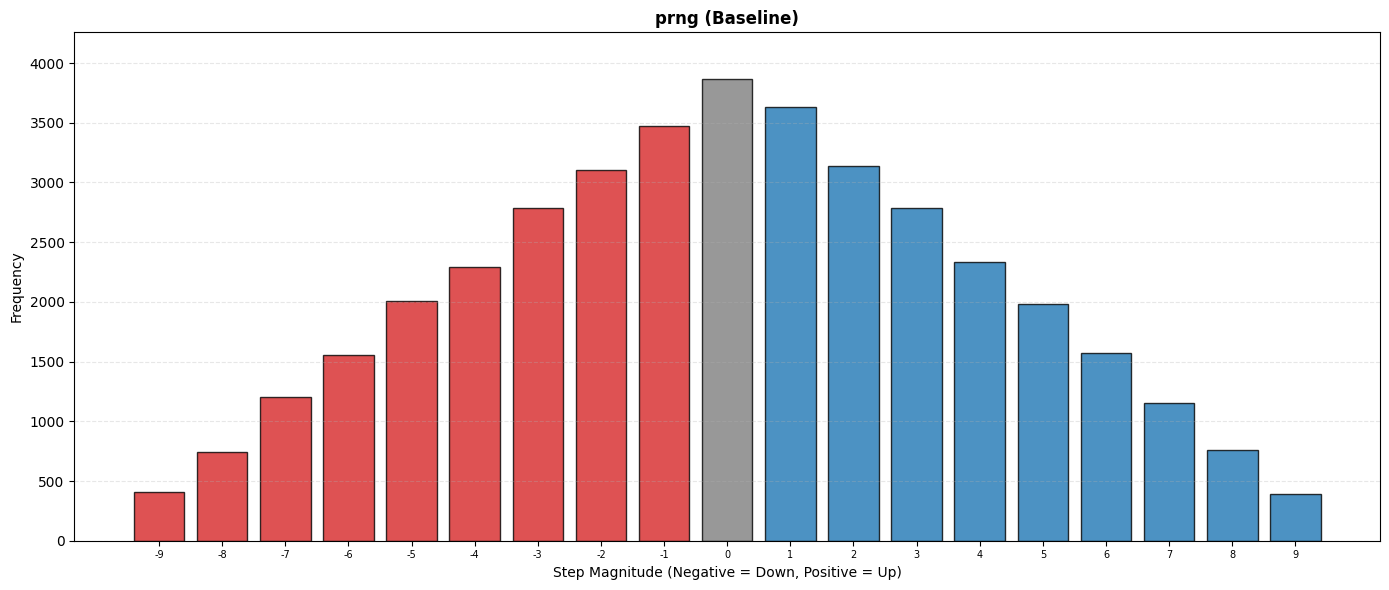

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import collections
import matplotlib.gridspec as gridspec

# ==========================================
# 1. SETUP
# ==========================================
custom_order = [
    'deepseek-chat-V3',             'deepseek-chat-V3.2-exp',
    'gemini-2.5-flash-preview-05-20', 'gemini-2.5-flash',
    'gpt-3.5-turbo-0125',           'gpt-4.1-mini',
    'gpt-4.1-nano',                 'gpt-4.1',
    'gpt-5-nano-2025-08-07',        'gpt-5-2025-08-07'
]
center_model = 'prng'
all_models = df['model_name'].unique().tolist()

# ==========================================
# 2. STEP DIFFERENCE LOGIC
# ==========================================
def get_step_differences(seq):
    """
    Calculates x[i+1] - x[i].
    Range for digits 1-10 is -9 to +9.
    """
    if isinstance(seq, str):
        try:
             clean = seq.replace('[', '').replace(']', '').replace('...', '')
             seq = [int(x.strip()) for x in clean.split(',') if x.strip().isdigit()]
        except: return []

    if len(seq) < 2: return []

    diffs = [seq[i+1] - seq[i] for i in range(len(seq)-1)]
    return diffs

# Possible range: -9 (10->1) to +9 (1->10)
min_diff = -9
max_diff = 9
diff_range = range(min_diff, max_diff + 1)

results = {}
for model in all_models:
    subset = df[df['model_name'] == model]
    model_counts = collections.Counter()

    for seq in subset['parsed_seq']:
        diffs = get_step_differences(seq)
        model_counts.update(diffs)
    results[model] = model_counts

# ==========================================
# 3. PLOTTING FUNCTION
# ==========================================
def plot_step_distribution(ax, model_name, counts, y_limit=None):
    x_vals = list(diff_range)
    y_vals = [counts.get(x, 0) for x in x_vals]

    colors = []
    for x in x_vals:
        if x == 0:
            colors.append('#7f7f7f')
        elif x < 0:
            colors.append('#d62728')
        else:
            colors.append('#1f77b4')

    ax.bar(x_vals, y_vals, color=colors, edgecolor='black', alpha=0.8)

    ax.set_title(model_name, fontsize=12, fontweight='bold')

    ax.set_xticks(np.arange(-9, 10, 1))

    ax.set_xticklabels(np.arange(-9, 10, 1), fontsize=7)

    if y_limit:
        ax.set_ylim(0, y_limit)

    ax.grid(axis='y', linestyle='--', alpha=0.3)

# ==========================================
# 4. PLOT 1: SATELLITES
# ==========================================
satellite_models = [m for m in custom_order if m in all_models]

max_y = 0
for m in satellite_models:
    c = results[m]
    if len(c) > 0:
        max_y = max(max_y, max(c.values()))
y_lim = max_y * 1.1

n_cols = 2
n_rows = (len(satellite_models) + n_cols - 1) // n_cols

fig1 = plt.figure(figsize=(16, 4 * n_rows))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    ax = fig1.add_subplot(gs1[i // n_cols, i % n_cols])
    plot_step_distribution(ax, model, results[model], y_lim)
    if i % n_cols == 0: ax.set_ylabel("Frequency")

plt.suptitle("Step Size Distribution: Downward Steps (Left) vs Upward Jumps (Right)", fontsize=16, y=1.01)
plt.tight_layout()
plt.savefig('step_size_distribution_models.eps', format='eps', bbox_inches='tight')
plt.show()

# ==========================================
# 5. PLOT 2: TRUE RANDOM
# ==========================================
if center_model in all_models:
    fig2 = plt.figure(figsize=(14, 6))
    ax2 = fig2.add_subplot(111)

    # Independent scale for Random
    c = results[center_model]
    local_max = max(c.values()) if c else 0

    plot_step_distribution(ax2, center_model + " (Baseline)", c, local_max * 1.1)

    ax2.set_xlabel("Step Magnitude (Negative = Down, Positive = Up)")
    ax2.set_ylabel("Frequency")

    plt.tight_layout()
    plt.savefig('step_size_distribution_truerandom.eps', format='eps', bbox_inches='tight')
    plt.show()

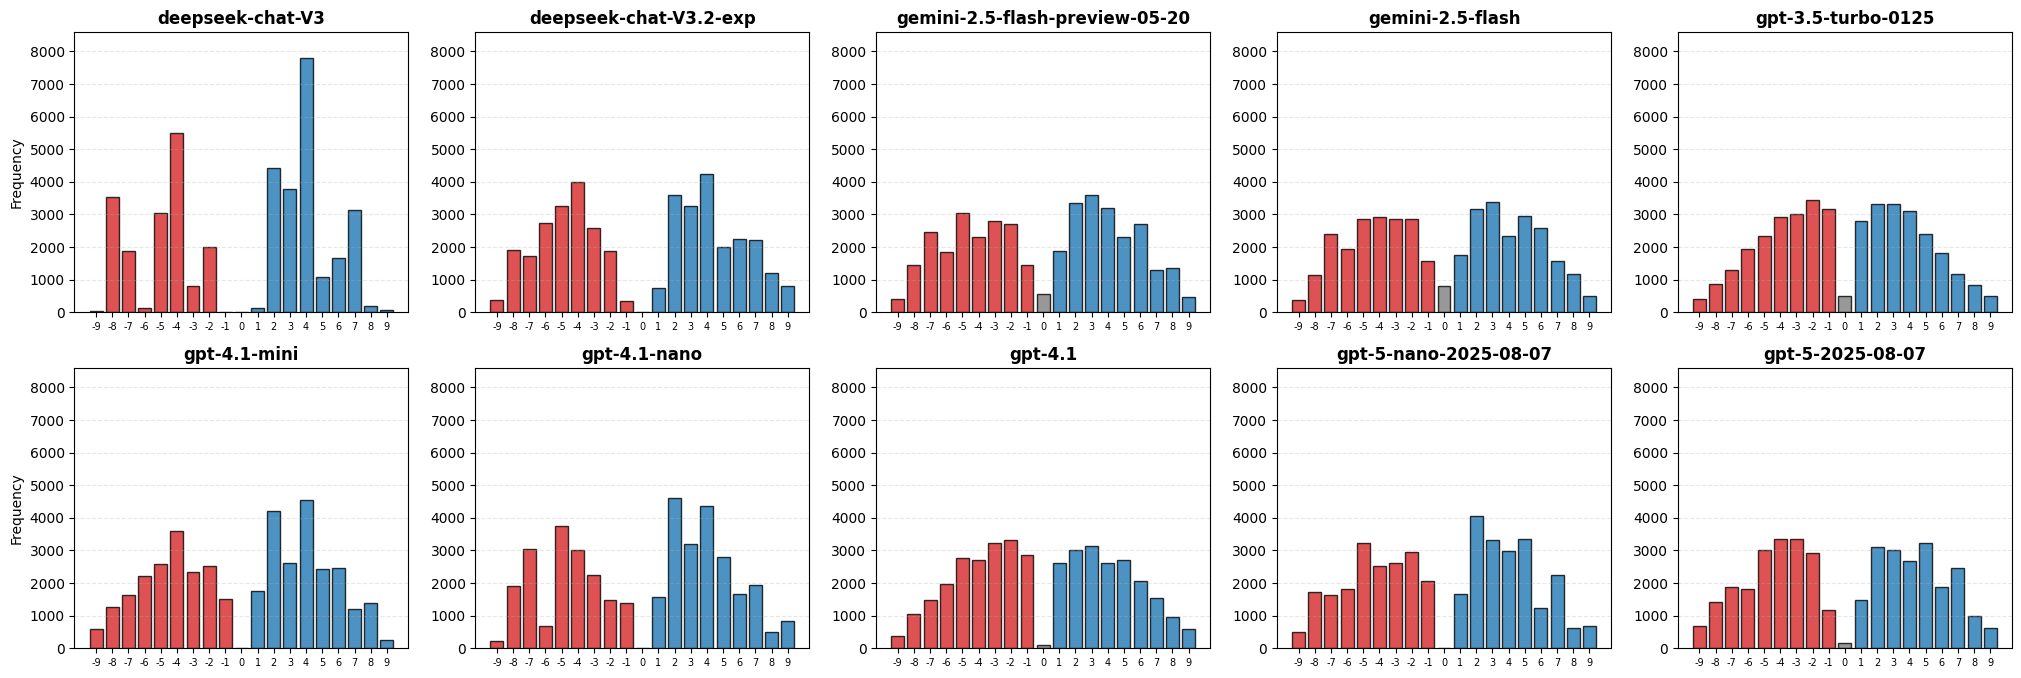

In [30]:
# --- 5x2 grid
n_rows = 2
n_cols = 5

fig1 = plt.figure(figsize=(5 * n_cols, 4 * n_rows))
gs1 = gridspec.GridSpec(n_rows, n_cols, figure=fig1)

for i, model in enumerate(satellite_models):
    row_idx = i // n_cols
    col_idx = i % n_cols
    ax = fig1.add_subplot(gs1[row_idx, col_idx])

    plot_step_distribution(ax, model, results[model], y_lim)

    if col_idx == 0:
        ax.set_ylabel("Frequency")


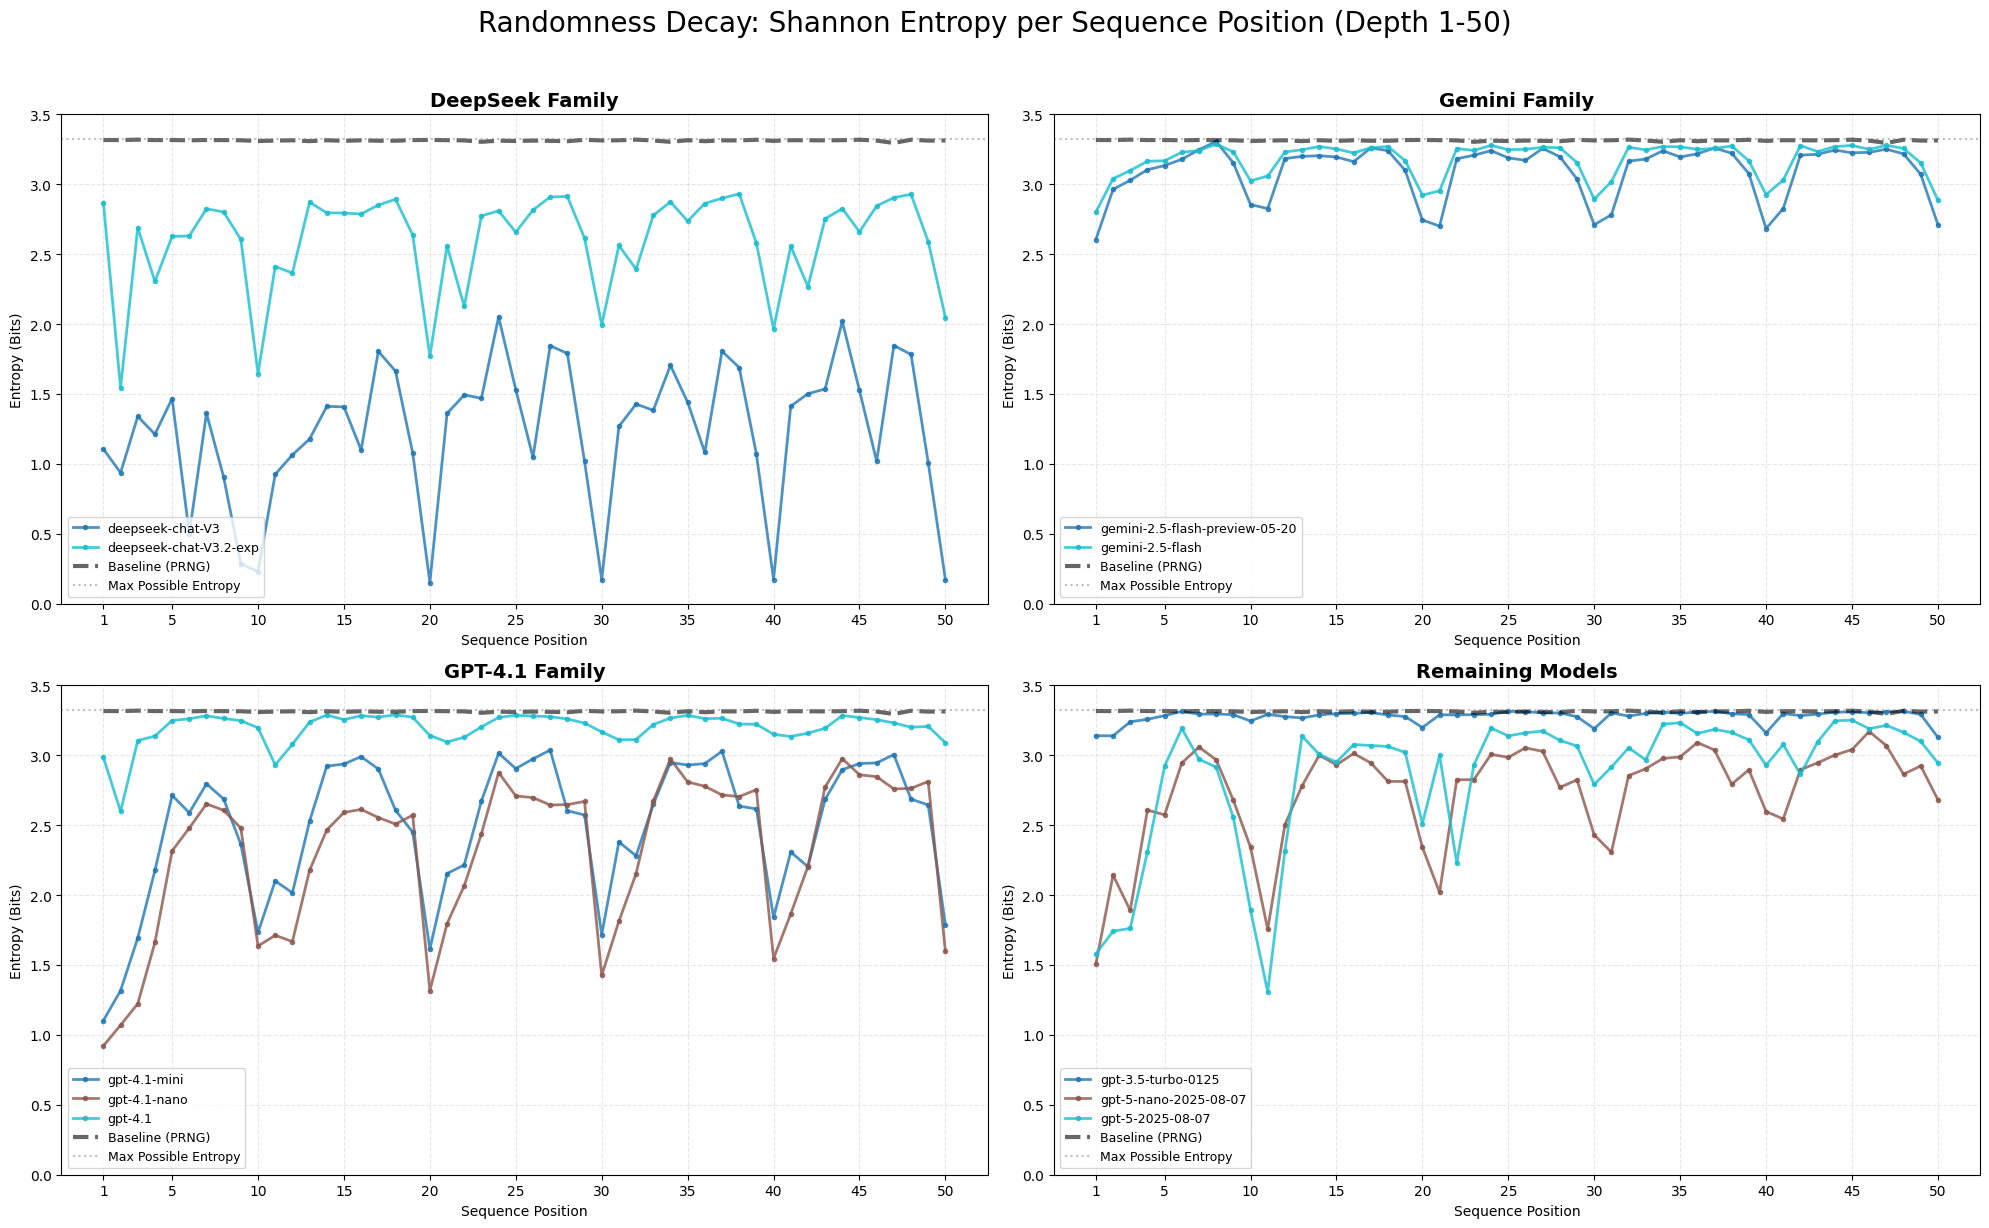

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import collections
from scipy.stats import entropy
import matplotlib.gridspec as gridspec

# Assuming 'df' is loaded from previous steps
if 'model_name' in df.columns:
    df['model_name'] = df['model_name'].replace(['deepseek-chat', 'deepseek-V3.2-Exp','deepseek-chat-V3.2'], 'deepseek-chat-V3.2-exp')

all_models = df['model_name'].unique().tolist()
center_model = 'prng'
MAX_DEPTH = 50

families = {
    "DeepSeek Family": ['deepseek-chat-V3', 'deepseek-chat-V3.2-exp'],
    "Gemini Family": ['gemini-2.5-flash-preview-05-20', 'gemini-2.5-flash'],
    "GPT-4.1 Family": ['gpt-4.1-mini', 'gpt-4.1-nano', 'gpt-4.1'],
    "Remaining Models": ['gpt-3.5-turbo-0125', 'gpt-5-nano-2025-08-07', 'gpt-5-2025-08-07']
}

def calculate_positional_entropy(subset, max_depth):
    entropies = []
    for d in range(max_depth):
        col_values = [seq[d] for seq in subset['parsed_seq'] if len(seq) > d]

        if not col_values:
            entropies.append(0)
            continue

        counts = collections.Counter(col_values)
        total = sum(counts.values())
        probs = np.array([c/total for c in counts.values()])

        ent = entropy(probs, base=2)
        entropies.append(ent)

    return entropies

results = {}
for model in all_models:
    subset = df[df['model_name'] == model]
    results[model] = calculate_positional_entropy(subset, MAX_DEPTH)

fig, axes = plt.subplots(2, 2, figsize=(20, 12))
axes = axes.flatten()

max_ent = 3.3219

for idx, (family_name, member_models) in enumerate(families.items()):
    ax = axes[idx]
    x_vals = np.arange(1, MAX_DEPTH + 1)

    colors = plt.cm.tab10(np.linspace(0, 1, len(member_models)))

    for i, model in enumerate(member_models):
        if model in results:
            y_vals = results[model]
            current_x = x_vals[:len(y_vals)]
            ax.plot(current_x, y_vals, marker='o', markersize=3, linewidth=2, alpha=0.8, label=model, color=colors[i])

    if center_model in results:
        y_vals = results[center_model]
        current_x = x_vals[:len(y_vals)]
        ax.plot(current_x, y_vals, linewidth=3, color='black', linestyle='--', label='Baseline (PRNG)', alpha=0.6)

    ax.axhline(y=max_ent, color='grey', linestyle=':', alpha=0.5, label="Max Possible Entropy")

    ax.set_title(family_name, fontsize=14, fontweight='bold')
    ax.set_xlabel("Sequence Position", fontsize=10)
    ax.set_ylabel("Entropy (Bits)", fontsize=10)
    ax.set_ylim(0, 3.5)

    ticks = np.arange(0, MAX_DEPTH + 1, 5)
    ticks[0] = 1
    ax.set_xticks(ticks)

    ax.grid(True, linestyle='--', alpha=0.3)
    ax.legend(loc='lower left', fontsize=9)

plt.suptitle(f"Randomness Decay: Shannon Entropy per Sequence Position (Depth 1-{MAX_DEPTH})", fontsize=20, y=1.02)
plt.tight_layout()
plt.savefig('shannon_entropy_plot.eps', format='eps', bbox_inches='tight') # Save the plot as EPS
plt.show()

In [54]:
import sys
print(sys.version)

3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [55]:
import pandas as pd


# Function to check for uniqueness in a sub-sequence
def check_uniqueness(sequence_part):
    # Convert to set to check for unique elements
    return len(set(sequence_part)) == len(sequence_part)

# Prepare a dictionary to store results
uniqueness_results = []

# Get all unique model names
all_models = df['model_name'].unique()

for model_name in all_models:
    # Filter sequences for the current model
    model_sequences = df[df['model_name'] == model_name]['parsed_seq']

    # Initialize counters for the current model
    total_sequences = 0
    unique_first_10_count = 0
    unique_next_10_count = 0

    for seq in model_sequences:
        # Ensure sequence is long enough for both parts (at least 20 numbers)
        if len(seq) >= 20:
            total_sequences += 1

            first_10 = seq[0:10]
            next_10 = seq[10:20]

            if check_uniqueness(first_10):
                unique_first_10_count += 1
            if check_uniqueness(next_10):
                unique_next_10_count += 1

    # Calculate percentages
    percentage_unique_first_10 = (unique_first_10_count / total_sequences * 100) if total_sequences > 0 else 0
    percentage_unique_next_10 = (unique_next_10_count / total_sequences * 100) if total_sequences > 0 else 0

    uniqueness_results.append({
        'Model': model_name,
        'Percentage Unique (First 10)': percentage_unique_first_10,
        'Percentage Unique (Next 10)': percentage_unique_next_10,
        'Total Sequences Analyzed': total_sequences
    })

df_uniqueness = pd.DataFrame(uniqueness_results)

df_uniqueness = df_uniqueness.sort_values(by='Percentage Unique (First 10)', ascending=False).reset_index(drop=True)

print("Sequence Uniqueness Analysis:")
display(df_uniqueness)


Sequence Uniqueness Analysis:


Model  Percentage Unique (First 10)  \
0                 deepseek-chat-V3                       100.000   
1           deepseek-chat-V3.2-exp                       100.000   
2                     gpt-4.1-mini                        99.375   
3                 gpt-5-2025-08-07                        99.250   
4            gpt-5-nano-2025-08-07                        98.625   
5                     gpt-4.1-nano                        93.375   
6   gemini-2.5-flash-preview-05-20                        71.500   
7                          gpt-4.1                        66.000   
8                 gemini-2.5-flash                        53.375   
9               gpt-3.5-turbo-0125                        35.250   
10                            prng                         0.125   

    Percentage Unique (Next 10)  Total Sequences Analyzed  
0                       100.000                       800  
1                       100.000                       800  
2                        98.625                       800  
3                        98.125                       800  
4                        93.125                       800  
5                        97.000                       800  
6                        78.375                       800  
7                        55.375                       800  
8                        66.125                       800  
9                        34.250                       800  
10                        0.000                       800

In [56]:
from scipy.stats import chisquare, kstest, spearmanr
import numpy as np
import math


def chi_square_uniform(seq):
    # Filter sequence to only include numbers in the range [1, 10]
    filtered_seq = [x for x in seq if 1 <= x <= 10]
    if not filtered_seq: # Handle empty sequence case after filtering
        return np.nan, np.nan

    counts = np.bincount(filtered_seq, minlength=11)[1:11]
    expected = np.ones(10) * (len(filtered_seq) / 10)
    chi2, p = chisquare(counts, expected)
    return chi2, p

def first_position_test(sequences):
    first_vals = [seq[0] for seq in sequences if len(seq) > 0]
    return chi_square_uniform(first_vals)

def serial_correlation(seq):
    if len(seq) < 2:
        return np.nan, np.nan
    return spearmanr(seq[:-1], seq[1:])

def runs_test(seq):
    median = np.median(seq)
    signs = [1 if x > median else 0 for x in seq if x != median]
    runs = 1
    for i in range(1, len(signs)):
        if signs[i] != signs[i-1]:
            runs += 1
    n1 = signs.count(1)
    n0 = signs.count(0)
    expected = (2*n1*n0)/(n1+n0) + 1
    variance = (2*n1*n0*(2*n1*n0 - n1 - n0))/(((n1+n0)**2)*(n1+n0-1))
    z = (runs - expected)/math.sqrt(variance) if variance > 0 else np.nan
    return runs, z

def entropy_test(seq):
    filtered_seq = [x for x in seq if 1 <= x <= 10]
    if not filtered_seq:
        return 0.0

    counts = np.bincount(filtered_seq, minlength=11)[1:11]
    if counts.sum() == 0:
        return 0.0

    probs = counts / counts.sum()
    entropy = -np.sum([p * math.log2(p) for p in probs if p > 0])
    return entropy

def pair_uniformity_test(seq):
    valid_pairs = []
    for i in range(len(seq)-1):
        a, b = seq[i], seq[i+1]
        if 1 <= a <= 10 and 1 <= b <= 10:
            valid_pairs.append((a, b))

    if not valid_pairs:
        return np.nan, np.nan

    pair_ids = [(a-1)*10 + (b-1) for a,b in valid_pairs]
    counts = np.bincount(pair_ids, minlength=100)
    expected = np.ones(100) * (len(pair_ids) / 100)
    chi2, p = chisquare(counts, expected)
    return chi2, p


results = []

for model_name in all_models:
    subset = df[df['model_name'] == model_name]
    sequences = subset['parsed_seq'].tolist()
    flat_seq = [num for seq in sequences for num in seq]

    chi2, chi_p = chi_square_uniform(flat_seq)
    first_chi2, first_p = first_position_test(sequences)
    rho, rho_p = serial_correlation(flat_seq)
    runs, runs_z = runs_test(flat_seq)
    entropy = entropy_test(flat_seq)
    pair_chi2, pair_p = pair_uniformity_test(flat_seq)

    results.append({
        'Model': model_name,
        'Chi-Squared Statistic': chi2,
        'Chi2 p-value': chi_p,
        'First Position p-value': first_p,
        'Serial Corr p-value': rho_p,
        'Runs Z-score': runs_z,
        'Entropy': entropy,
        'Pair Uniformity p-value': pair_p
    })

df_randomness = pd.DataFrame(results)
display(df_randomness)


Model  Chi-Squared Statistic  Chi2 p-value  \
0                 deepseek-chat-V3               0.000000  1.000000e+00   
1           deepseek-chat-V3.2-exp               0.000000  1.000000e+00   
2                 gemini-2.5-flash             195.975500  2.309657e-37   
3   gemini-2.5-flash-preview-05-20              98.611500  3.003084e-17   
4               gpt-3.5-turbo-0125              51.078856  6.747392e-08   
5                          gpt-4.1              53.299500  2.564513e-08   
6                     gpt-4.1-mini               0.073000  1.000000e+00   
7                     gpt-4.1-nano               3.643000  9.333015e-01   
8                 gpt-5-2025-08-07               0.085000  1.000000e+00   
9            gpt-5-nano-2025-08-07              37.719500  1.957113e-05   
10                            prng              11.694500  2.310849e-01   

    First Position p-value  Serial Corr p-value  Runs Z-score   Entropy  \
0             0.000000e+00         0.000000e+00     80.411005  3.321928   
1            1.723406e-111         0.000000e+00    113.451418  3.321928   
2            3.739046e-116         0.000000e+00     64.411082  3.318417   
3            1.767740e-188         0.000000e+00     74.401836  3.320157   
4             1.053082e-35        1.161134e-256     37.920983  3.320994   
5             2.337306e-56         0.000000e+00     57.360390  3.320968   
6             0.000000e+00         0.000000e+00     84.796260  3.321927   
7             0.000000e+00         0.000000e+00     90.667439  3.321862   
8             0.000000e+00         0.000000e+00     93.238300  3.321927   
9             0.000000e+00         0.000000e+00     80.787617  3.321251   
10            7.298696e-01         8.800592e-01      0.277548  3.321717   

    Pair Uniformity p-value  
0                  0.000000  
1                  0.000000  
2                  0.000000  
3                  0.000000  
4                  0.000000  
5                  0.000000  
6                  0.000000  
7                  0.000000  
8                  0.000000  
9                  0.000000  
10                 0.305657

In [57]:
import pandas as pd

df_chi_squared_summary = df_randomness[['Model', 'Chi-Squared Statistic', 'Chi2 p-value']]

alpha = 0.05
df_chi_squared_summary['Interpretation'] = df_chi_squared_summary['Chi2 p-value'].apply(
    lambda p: f"Statistically significant deviation (p < {alpha})" if p < alpha
    else f"No statistically significant deviation (p >= {alpha})")

print("Summary of Chi-Squared Test for Uniformity (1-10 distribution):")
display(df_chi_squared_summary)


Summary of Chi-Squared Test for Uniformity (1-10 distribution):


/tmp/ipython-input-1954965182.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_chi_squared_summary['Interpretation'] = df_chi_squared_summary['Chi2 p-value'].apply(


Model  Chi-Squared Statistic  Chi2 p-value  \
0                 deepseek-chat-V3               0.000000  1.000000e+00   
1           deepseek-chat-V3.2-exp               0.000000  1.000000e+00   
2                 gemini-2.5-flash             195.975500  2.309657e-37   
3   gemini-2.5-flash-preview-05-20              98.611500  3.003084e-17   
4               gpt-3.5-turbo-0125              51.078856  6.747392e-08   
5                          gpt-4.1              53.299500  2.564513e-08   
6                     gpt-4.1-mini               0.073000  1.000000e+00   
7                     gpt-4.1-nano               3.643000  9.333015e-01   
8                 gpt-5-2025-08-07               0.085000  1.000000e+00   
9            gpt-5-nano-2025-08-07              37.719500  1.957113e-05   
10                            prng              11.694500  2.310849e-01   

                                       Interpretation  
0   No statistically significant deviation (p >= 0...  
1   No statistically significant deviation (p >= 0...  
2      Statistically significant deviation (p < 0.05)  
3      Statistically significant deviation (p < 0.05)  
4      Statistically significant deviation (p < 0.05)  
5      Statistically significant deviation (p < 0.05)  
6   No statistically significant deviation (p >= 0...  
7   No statistically significant deviation (p >= 0...  
8   No statistically significant deviation (p >= 0...  
9      Statistically significant deviation (p < 0.05)  
10  No statistically significant deviation (p >= 0...

/tmp/ipython-input-1317688561.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Serial Correlation (rho)', y='Model', data=df_serial_corr, palette='viridis')


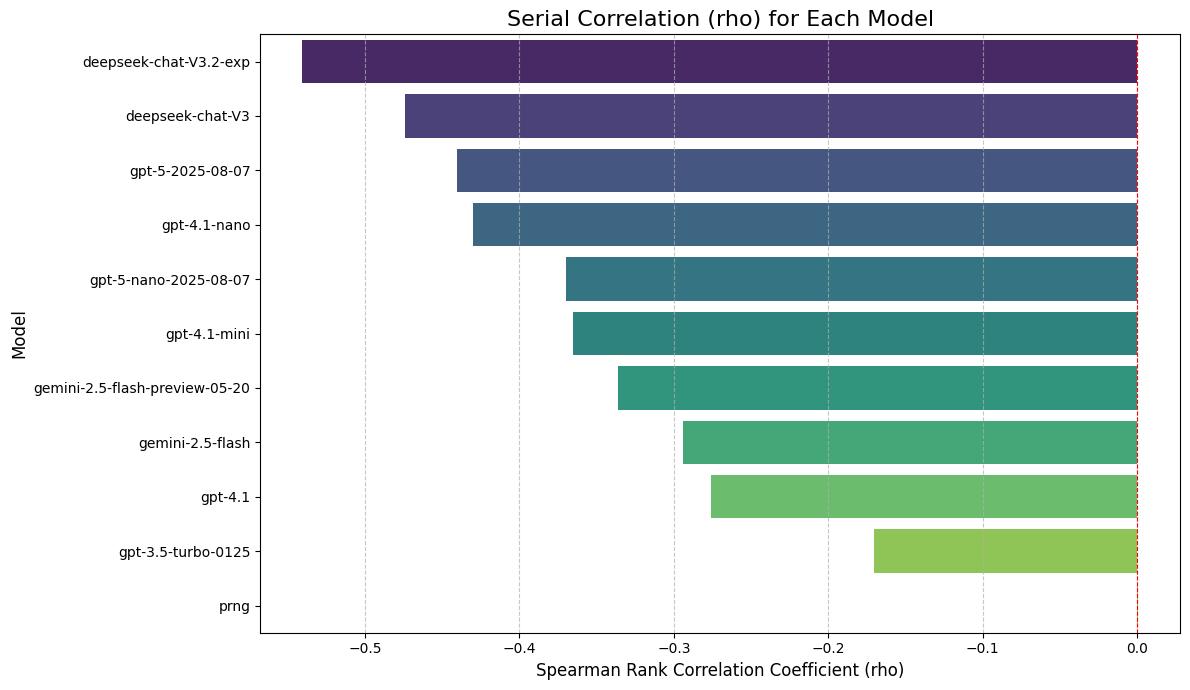

Model  Serial Correlation (rho)
1           deepseek-chat-V3.2-exp                 -0.540864
0                 deepseek-chat-V3                 -0.474098
8                 gpt-5-2025-08-07                 -0.440191
7                     gpt-4.1-nano                 -0.430398
9            gpt-5-nano-2025-08-07                 -0.369621
6                     gpt-4.1-mini                 -0.365405
3   gemini-2.5-flash-preview-05-20                 -0.336024
2                 gemini-2.5-flash                 -0.294110
5                          gpt-4.1                 -0.276220
4               gpt-3.5-turbo-0125                 -0.170066
10                            prng                  0.000755

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

serial_correlations = []

for model_name in all_models:
    subset = df[df['model_name'] == model_name]
    sequences = subset['parsed_seq'].tolist()
    flat_seq = [num for seq in sequences for num in seq if 1 <= num <= 10]

    rho, _ = serial_correlation(flat_seq)
    serial_correlations.append({'Model': model_name, 'Serial Correlation (rho)': rho})

df_serial_corr = pd.DataFrame(serial_correlations)

df_serial_corr['Abs_Corr'] = df_serial_corr['Serial Correlation (rho)'].abs()
df_serial_corr = df_serial_corr.sort_values(by='Abs_Corr', ascending=False).drop(columns='Abs_Corr')

plt.figure(figsize=(12, 7))
sns.barplot(x='Serial Correlation (rho)', y='Model', data=df_serial_corr, palette='viridis')
plt.title('Serial Correlation (rho) for Each Model', fontsize=16)
plt.xlabel('Spearman Rank Correlation Coefficient (rho)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.axvline(0, color='red', linestyle='--', linewidth=0.8)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

display(df_serial_corr)

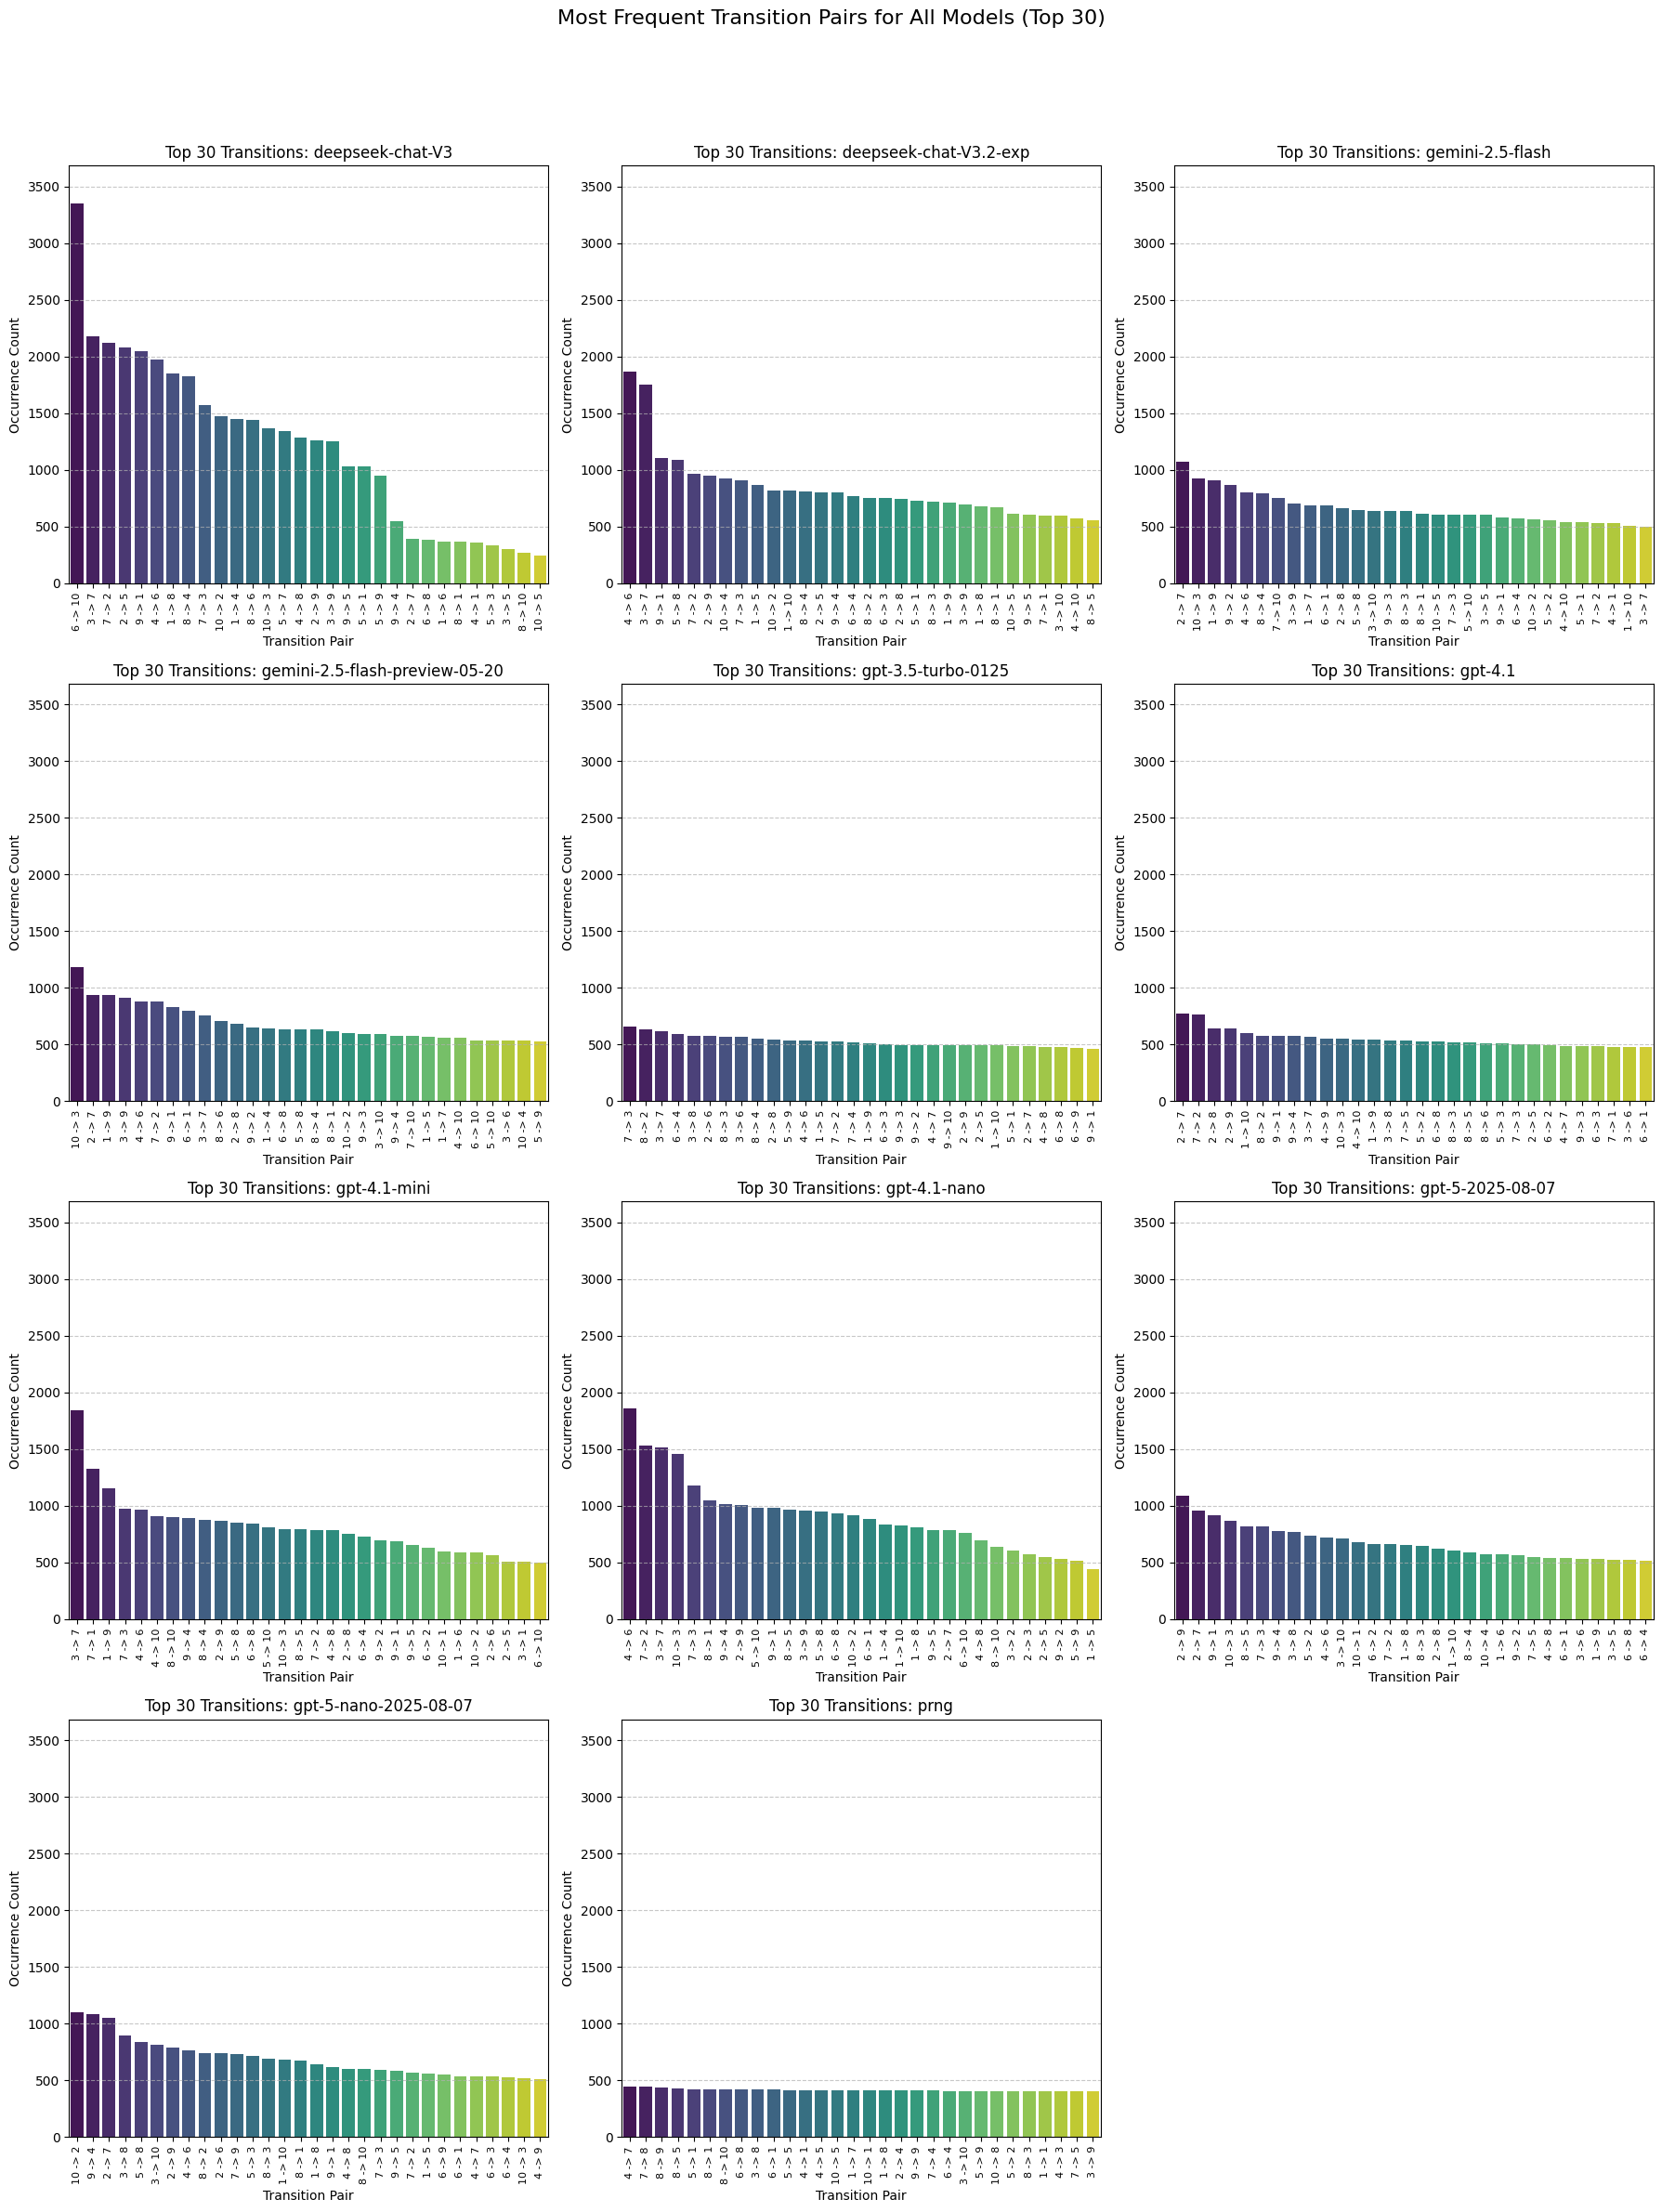

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import pandas as pd

all_models = df['model_name'].unique()
num_models = len(all_models)

n_cols = 3
n_rows = math.ceil(num_models / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), squeeze=False)
axes = axes.flatten()

top_n_transitions_to_show = 30

all_df_transitions = []
for model_name in all_models:
    mat = np.zeros((10, 10))
    subset_sequences = df[df['model_name'] == model_name]['parsed_seq']

    for seq in subset_sequences:
        for j in range(len(seq) - 1):
            current_val = seq[j]
            next_val = seq[j+1]
            if 1 <= current_val <= 10 and 1 <= next_val <= 10:
                mat[current_val - 1, next_val - 1] += 1

    transitions_list = []
    for row_idx in range(10):
        for col_idx in range(10):
            from_num = row_idx + 1
            to_num = col_idx + 1
            count = mat[row_idx, col_idx]
            if count > 0:
                transitions_list.append({'Transition': f'{from_num} -> {to_num}', 'Count': count})

    df_transitions_model = pd.DataFrame(transitions_list).sort_values(by='Count', ascending=False)
    all_df_transitions.append(df_transitions_model)

global_max_count = 0
for df_model in all_df_transitions:
    if not df_model.empty:
        global_max_count = max(global_max_count, df_model['Count'].head(top_n_transitions_to_show).max())

for i, model_name in enumerate(all_models):
    df_transitions = all_df_transitions[i]
    ax = axes[i]

    if not df_transitions.empty:
        sns.barplot(
            x='Transition',
            y='Count',
            hue='Transition',
            legend=False,
            data=df_transitions.head(top_n_transitions_to_show),
            ax=ax,
            palette='viridis'
        )
        # -------------------------

        ax.set_title(f'Top {top_n_transitions_to_show} Transitions: {model_name}', fontsize=12)
        ax.set_xlabel('Transition Pair', fontsize=10)
        ax.set_ylabel('Occurrence Count', fontsize=10)
        ax.tick_params(axis='x', rotation=90, labelsize=8)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        ax.set_ylim(0, global_max_count * 1.1)
    else:
        ax.set_title(f'Top {top_n_transitions_to_show} Transitions: {model_name}', fontsize=12)
        ax.text(0.5, 0.5, 'No transitions found (1-10 range)', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])


for i in range(num_models, len(axes)):
    fig.delaxes(axes[i])

plt.suptitle(f'Most Frequent Transition Pairs for All Models (Top {top_n_transitions_to_show})', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

In [64]:
import numpy as np
from scipy.stats import pearsonr

def lag1_autocorr(seq):
    if len(seq) < 2:
        return np.nan, np.nan
    return pearsonr(seq[:-1], seq[1:])  # (correlation, p-value)

results = []

for model in df['model_name'].unique():
    seqs = df[df['model_name'] == model]['parsed_seq']

    corrs = []
    pvals = []

    for seq in seqs:
        r, p = lag1_autocorr(seq)
        if not np.isnan(r):
            corrs.append(r)
            pvals.append(p)

    results.append({
        'Model': model,
        'Mean Lag-1 Correlation': np.mean(corrs),
        'Median Lag-1 Correlation': np.median(corrs),
        'Frac Significant (p<0.05)': np.mean(np.array(pvals) < 0.05)
    })

df_lag1 = pd.DataFrame(results)
display(df_lag1)


Model  Mean Lag-1 Correlation  \
0                 deepseek-chat-V3               -0.467421   
1           deepseek-chat-V3.2-exp               -0.546788   
2                 gemini-2.5-flash               -0.314907   
3   gemini-2.5-flash-preview-05-20               -0.351331   
4               gpt-3.5-turbo-0125               -0.177625   
5                          gpt-4.1               -0.281325   
6                     gpt-4.1-mini               -0.364117   
7                     gpt-4.1-nano               -0.446181   
8                 gpt-5-2025-08-07               -0.442776   
9            gpt-5-nano-2025-08-07               -0.379064   
10                            prng               -0.019186   

    Median Lag-1 Correlation  Frac Significant (p<0.05)  
0                  -0.516451                    0.92625  
1                  -0.541519                    0.96500  
2                  -0.316553                    0.57125  
3                  -0.359910                    0.62500  
4                  -0.172513                    0.26875  
5                  -0.285816                    0.51500  
6                  -0.372911                    0.73625  
7                  -0.457423                    0.81625  
8                  -0.457783                    0.90000  
9                  -0.390279                    0.74625  
10                 -0.019859                    0.04875

In [78]:
import pandas as pd
import numpy as np
from scipy.stats import kstest, ks_2samp


# Flatten sequence data for a given model
def flatten_sequences_for_model(model_name_filter):
    subset = df[df['model_name'] == model_name_filter]
    # Only include numbers between 1 and 10, as specified in previous randomness tests
    flattened_seq = [num for seq in subset['parsed_seq'] for num in seq if 1 <= num <= 10]
    return np.array(flattened_seq)

# Get the reference 'prng' distribution
prng_distribution = flatten_sequences_for_model('prng')

if len(prng_distribution) == 0:
    print("Error: 'prng' distribution is empty. Cannot perform KS test.")
else:
    results = []
    alpha = 0.05

    all_models = df['model_name'].unique()

    for model_name in all_models:
        if model_name == 'prng':
            # Skip prng as it's the reference
            continue

        model_distribution = flatten_sequences_for_model(model_name)

        if len(model_distribution) == 0:
            results.append({
                'Model': model_name,
                'KS Statistic': np.nan,
                'P-value': np.nan,
                'Interpretation': 'No data for model'
            })
            continue

        # Perform two-sample Kolmogorov-Smirnov test
        ks_stat, p_value = ks_2samp(model_distribution, prng_distribution)

        # Interpret significance
        if p_value < alpha:
            interpretation = 'Yes'
        else:
            interpretation = 'No'

        results.append({
            'Model': model_name,
            'KS Statistic': ks_stat,
            'P-value': p_value,
            'Different to PRNG': interpretation
        })

    # Create DataFrame for results and display
    df_ks_results = pd.DataFrame(results)
    df_ks_results = df_ks_results.sort_values(by='P-value', ascending=True).reset_index(drop=True)

    print("\nKolmogorov-Smirnov Test Results (vs. PRNG Distribution):")
    display(df_ks_results)



Kolmogorov-Smirnov Test Results (vs. PRNG Distribution):


Model  KS Statistic   P-value Different to PRNG
0                gemini-2.5-flash      0.014250  0.000588               Yes
1  gemini-2.5-flash-preview-05-20      0.010025  0.035664               Yes
2           gpt-5-nano-2025-08-07      0.008125  0.141811                No
3              gpt-3.5-turbo-0125      0.007368  0.226577                No
4                         gpt-4.1      0.006200  0.423828                No
5                    gpt-4.1-nano      0.003875  0.923638                No
6                gpt-5-2025-08-07      0.002200  0.999974                No
7          deepseek-chat-V3.2-exp      0.002125  0.999989                No
8                deepseek-chat-V3      0.002125  0.999989                No
9                    gpt-4.1-mini      0.002075  0.999994                No

--- Analysis Results ---
                             Model  % Perfect Urn (First 10)  \
0                 deepseek-chat-V3                   1.00000   
1           deepseek-chat-V3.2-exp                   1.00000   
2                 gemini-2.5-flash                   0.53375   
3   gemini-2.5-flash-preview-05-20                   0.71500   
4               gpt-3.5-turbo-0125                   0.35250   
5                          gpt-4.1                   0.66000   
6                     gpt-4.1-mini                   0.99375   
7                     gpt-4.1-nano                   0.93375   
8                 gpt-5-2025-08-07                   0.99250   
9            gpt-5-nano-2025-08-07                   0.98625   
10                            prng                   0.00125   

    Avg Steps to Collect All  Avg Immediate Repeats  
0                   10.00000                 0.0000  
1                   10.00000                 0.0000  
2                   15.37250                

/tmp/ipython-input-1305057243.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='model_name', y='steps_to_full_set', palette="Set2")
/tmp/ipython-input-1305057243.py:66: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='model_name', y='immediate_repeats', palette="Set2")


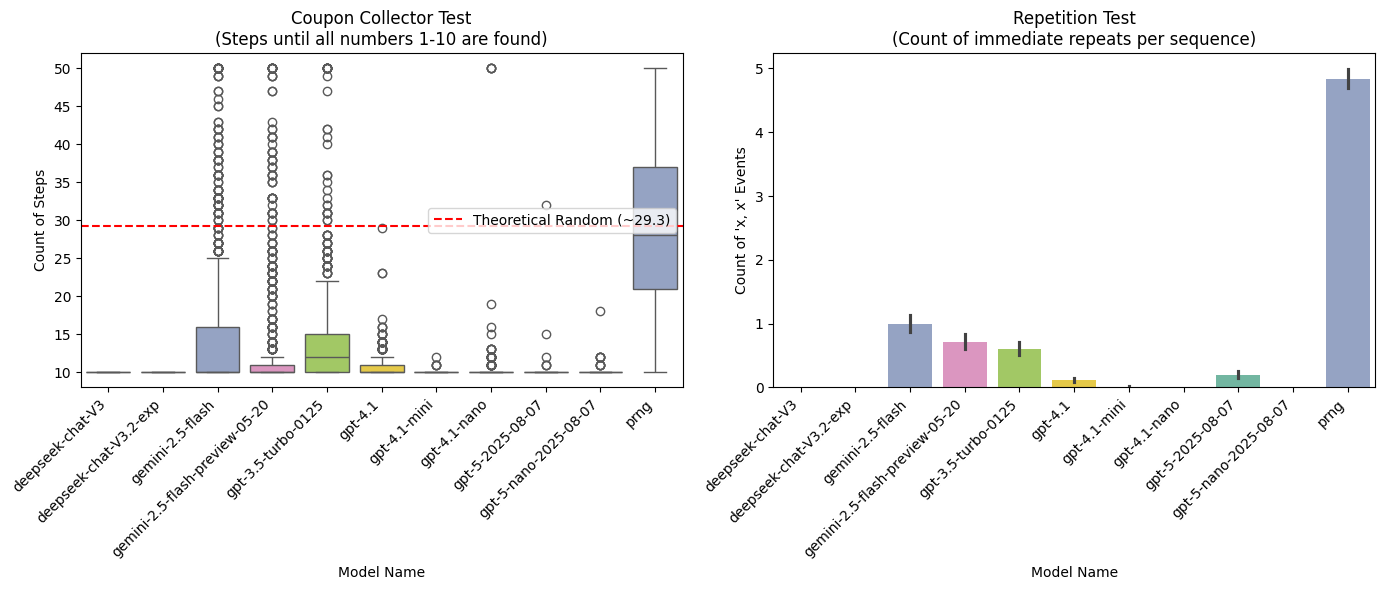

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Check Sampling without replacement (Urn Model) ---
def check_perfect_urn(seq):
    # Checks if the first 10 numbers are unique (1-10 permutation)
    if len(seq) < 10: return False
    first_10 = seq[:10]
    return len(set(first_10)) == 10

# --- 2. "Coupon Collector" Test ---
def steps_to_complete_set(seq, target_set=set(range(1, 11))):
    # counts how many steps it takes to see every number from 1 to 10
    seen = set()
    for i, num in enumerate(seq):
        seen.add(num)
        if seen == target_set:
            return i + 1
    return len(seq)

# --- 3. Immediate Repeat Test ---
def count_immediate_repeats(seq):
    # Counts how often a number is immediately followed by itself
    return sum(1 for i in range(len(seq)-1) if seq[i] == seq[i+1])

# Apply logic to DataFrame
# Note: Ensure your DataFrame 'df' has a column 'parsed_seq' containing lists of integers
df['is_urn_model'] = df['parsed_seq'].apply(check_perfect_urn)
df['steps_to_full_set'] = df['parsed_seq'].apply(steps_to_complete_set)
df['immediate_repeats'] = df['parsed_seq'].apply(count_immediate_repeats)

# Aggregate results
results = df.groupby('model_name').agg({
    'is_urn_model': 'mean',
    'steps_to_full_set': 'mean',
    'immediate_repeats': 'mean'
}).reset_index()

# Renaming columns for English output
results.columns = ['Model', '% Perfect Urn (First 10)', 'Avg Steps to Collect All', 'Avg Immediate Repeats']

print("--- Analysis Results ---")
print(results)

# --- Plotting ---
plt.figure(figsize=(14, 6)) # Increased width slightly for better spacing

# Plot 1: Coupon Collector
plt.subplot(1, 2, 1)
sns.boxplot(data=df, x='model_name', y='steps_to_full_set', palette="Set2")
plt.title("Coupon Collector Test\n(Steps until all numbers 1-10 are found)")
plt.ylabel("Count of Steps")
plt.xlabel("Model Name")

# Rotate x-labels to prevent overlap
plt.xticks(rotation=45, ha='right')

# Theoretical Expectation Line (~29.3 for n=10)
plt.axhline(29.3, color='red', linestyle='--', label='Theoretical Random (~29.3)')
plt.legend()

# Plot 2: Immediate Repeats
plt.subplot(1, 2, 2)
sns.barplot(data=df, x='model_name', y='immediate_repeats', palette="Set2")
plt.title("Repetition Test\n(Count of immediate repeats per sequence)")
plt.ylabel("Count of 'x, x' Events")
plt.xlabel("Model Name")

# Rotate x-labels to prevent overlap
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

Generiere Plots...


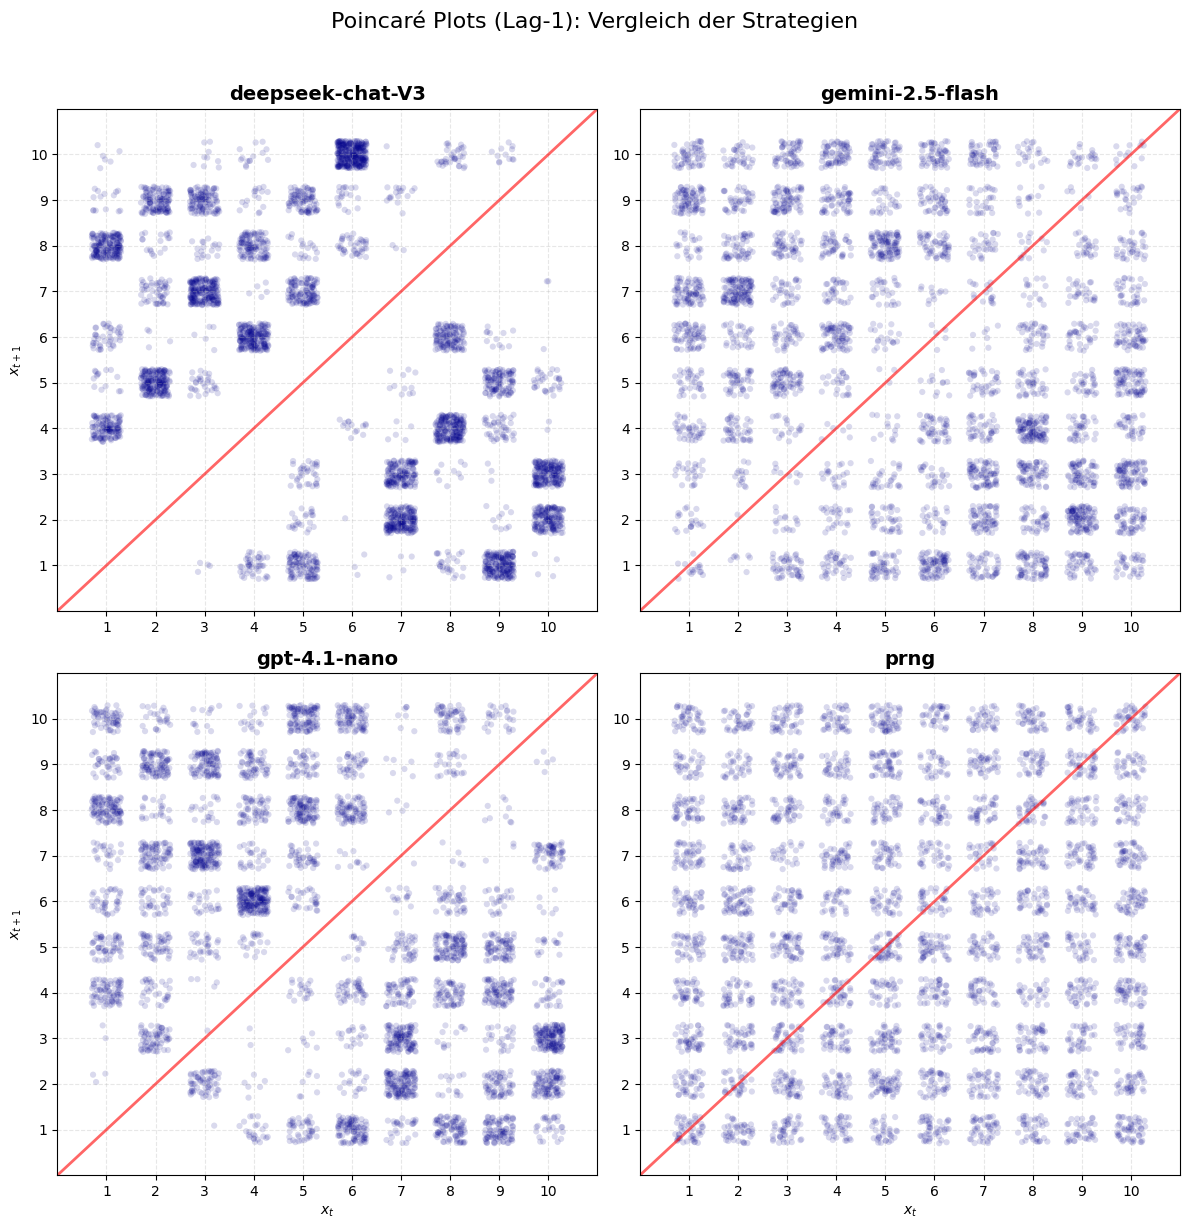

In [72]:
import matplotlib.pyplot as plt
import numpy as np

target_models = [
    'deepseek-chat-V3',
    'gemini-2.5-flash',
    'gpt-4.1-nano',
    'prng'
]

# Grid Setup (2x2)
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for i, model_name in enumerate(target_models):
    ax = axes[i]
    subset = df[df['model_name'] == model_name]

    if len(subset) == 0:
        ax.text(0.5, 0.5, f"Keine Daten für:\n{model_name}",
                ha='center', va='center', fontsize=12, color='red')
        ax.set_title(model_name)
        continue

    all_sequences = subset['parsed_seq'].tolist()
    all_numbers = [num for seq in all_sequences for num in seq]

    if len(all_numbers) > 4000:
        all_numbers = all_numbers[:4000]

    # Lag-Pairs
    x_t = np.array(all_numbers[:-1])
    x_t1 = np.array(all_numbers[1:])

    jitter = 0.3
    j_x = np.random.uniform(-jitter, jitter, size=len(x_t))
    j_y = np.random.uniform(-jitter, jitter, size=len(x_t1))

    # Scatterplot
    ax.scatter(x_t + j_x, x_t1 + j_y,
               alpha=0.15, s=20, c='darkblue', edgecolors='none')

    # Styling
    ax.set_title(f"{model_name}", fontsize=14, fontweight='bold')
    ax.set_xlim(0, 11)
    ax.set_ylim(0, 11)
    ax.set_xticks(range(1, 11))
    ax.set_yticks(range(1, 11))
    ax.grid(True, alpha=0.3, linestyle='--')

    ax.plot([0, 11], [0, 11], 'r-', linewidth=2, alpha=0.6, label='Diagonale (Wiederholung)')

    if i % 2 == 0: ax.set_ylabel("$x_{t+1}$")
    if i >= 2: ax.set_xlabel("$x_t$")

plt.suptitle("Poincaré Plots (Lag-1): Vergleich der Strategien", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [74]:
count_4798 = 0
count_8974 = 0

for seq_list in df['parsed_seq']:
    for num in seq_list:
        if num == 4798:
            count_4798 += 1
        elif num == 8974:
            count_8974 += 1

print(f"Number 4798 appears {count_4798} times in all sequences.")
print(f"Number 8974 appears {count_8974} times in all sequences.")

Number 4798 appears 0 times in all sequences.
Number 8974 appears 0 times in all sequences.


In [76]:
import pandas as pd

target_sequences = {
    '4,7,9,8': [4, 7, 9, 8],
    '8,9,7,4': [8, 9, 7, 4],
    '7,4,9,8': [7, 4, 9, 8],
}

sequence_counts = {
    model_name: {seq_key: 0 for seq_key in target_sequences.keys()}
    for model_name in df['model_name'].unique()
}

for index, row in df.iterrows():
    model = row['model_name']
    parsed_sequence = row['parsed_seq']


    for seq_key, target_seq in target_sequences.items():
        for i in range(len(parsed_sequence) - len(target_seq) + 1):
            if parsed_sequence[i:i+len(target_seq)] == target_seq:
                sequence_counts[model][seq_key] += 1

df_sequence_counts = pd.DataFrame.from_dict(sequence_counts, orient='index')
df_sequence_counts.index.name = 'Model'

print("Counts of target sequences per model:")
display(df_sequence_counts.sort_values(by=list(target_sequences.keys()), ascending=False))

Counts of target sequences per model:


4,7,9,8  8,9,7,4  7,4,9,8
Model                                                    
gpt-3.5-turbo-0125                    4        5        4
prng                                  4        3        1
gpt-4.1                               2        3        8
gemini-2.5-flash-preview-05-20        2        1        0
gemini-2.5-flash                      1        1        0
deepseek-chat-V3.2-exp                0        0        5
gpt-4.1-nano                          0        0        5
gpt-5-2025-08-07                      0        0        2
deepseek-chat-V3                      0        0        0
gpt-4.1-mini                          0        0        0
gpt-5-nano-2025-08-07                 0        0        0